In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('TSLA.csv')
print(df.shape)
df.head()

(2416, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


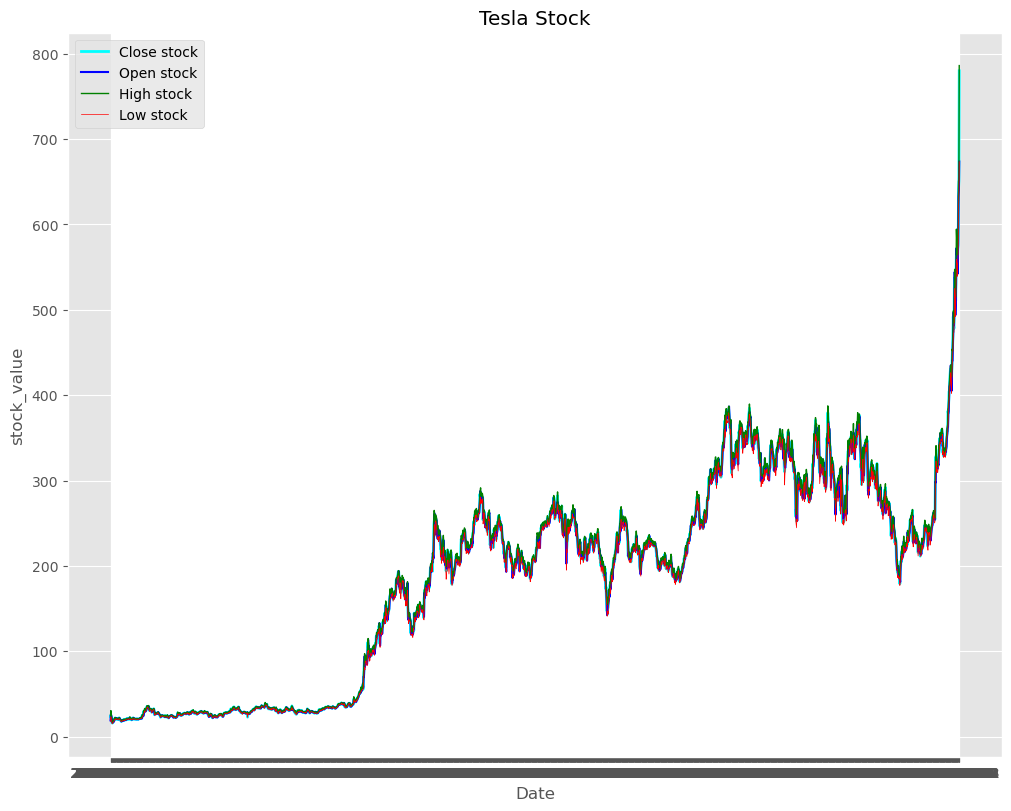

In [55]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [56]:
from PyEMD import CEEMDAN, Visualisation

In [57]:
close = df[['Close']].values

In [9]:
close

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

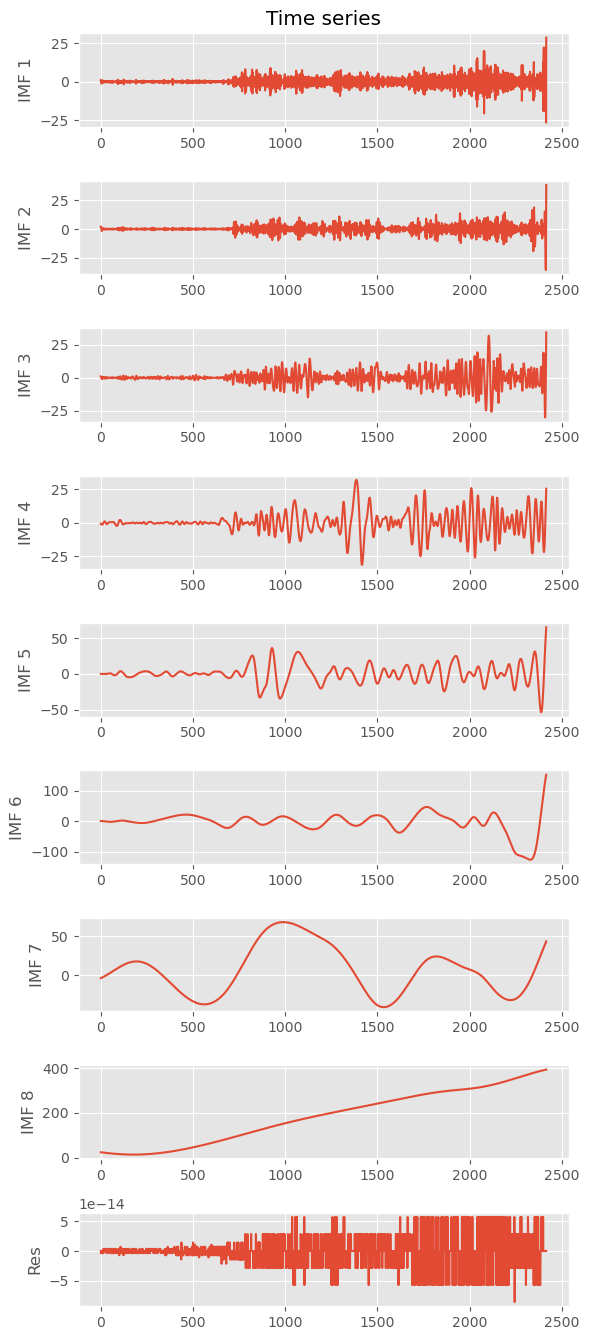

In [58]:
ceemdan = CEEMDAN()
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, 2416, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [50]:
imfs_close[1][2400:2440]

array([ -1.17000645,   0.61857087,   1.32586285,  -1.89675986,
        -4.53803571,  -1.94379581,   6.8806275 ,  15.0382744 ,
        15.15651882,   5.79918291,  -8.02865689, -20.61810305,
       -30.22341171, -35.06055467,  -7.23524696,  37.76305352])

In [59]:
# 取之前X_lag个数据来预测下一个数据
def time_slice(data,X_lag):
    sample = []
    label = []
    for k in range(len(data) - X_lag - 1):
        t = k + X_lag
        sample.append(data[k:t])
        label.append(data[t + 1])
    return sample,label


In [79]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import pandas as pd
import numpy as np
import time

In [80]:
def create_model():
    model = Sequential()
    model.add(LSTM(15, input_shape=(None,1)))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [81]:
def implement_LSTM(X_train, y_train):
    param_grid = {'epochs': [200, 250, 300, 350, 400, 450, 500], 
                              'batch_size': [4, 8, 16, 24, 32]}
    
    model = KerasRegressor(build_fn=create_model)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    
    return grid_search.best_estimator_

# def implement_LSTM(X_train, y_train):
#     model = Sequential()
#     model.add(LSTM(15, input_shape=(None,1)))
#     model.add(Dense(1))
#     model.summary()
#     model.compile(loss='mean_squared_error', optimizer='adam')
# #     model.compile(loss='mean_squared_error', optimizer='sgd')
#     model.fit(X_train, y_train, epochs=350, batch_size=16, verbose=0)
    
#     return model

In [62]:
def implement_BP(X_train, y_train):
    param_grid = {'hidden_layer_sizes': [(3,), (10,), (30,), (9,), (20,)], 'learning_rate_init': [0.001, 0.1, 0.2, 0.3, 0.01],
                  'max_iter': [8000]}
    model = MLPRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    
#     model = MLPRegressor(hidden_layer_sizes=(10,), random_state=10, learning_rate_init=0.1)  # BP神经网络回归模型
#     model.fit(X_train,y_train)  # 训练模型
    
    return grid_search.best_estimator_

In [63]:
def implement_IR(X_train, y_train):
#     model = IsotonicRegression()  
    model = LinearRegression()
    model.fit(X_train,y_train)  # 训练模型
    
    return model

In [64]:
def split(sample, label, test_ratio):
    length = len(label)
    train_len = round((1-test_ratio)*length)
    X_train = sample[0:train_len]
    X_test = sample[train_len+1:length]
    y_train = label[0:train_len]
    y_test = label[train_len+1:length]
    
    return X_train, X_test, y_train, y_test

In [52]:
X_test

[array([15.41251429, 15.24111054, 15.06804366, 14.89332048, 14.71694782,
        14.53893251, 14.35928137, 14.17800125, 13.99509895, 13.81058131,
        13.62445516, 13.43672733, 13.24740464, 13.05649391, 12.86400198,
        12.66993567, 12.47430182, 12.27710724, 12.07835876, 11.87806322,
        11.67622744, 11.47285824, 11.26796246, 11.06154692, 10.85361844,
        10.64418387, 10.43325001, 10.22082371, 10.00691178,  9.79152106]),
 array([15.24111054, 15.06804366, 14.89332048, 14.71694782, 14.53893251,
        14.35928137, 14.17800125, 13.99509895, 13.81058131, 13.62445516,
        13.43672733, 13.24740464, 13.05649391, 12.86400198, 12.66993567,
        12.47430182, 12.27710724, 12.07835876, 11.87806322, 11.67622744,
        11.47285824, 11.26796246, 11.06154692, 10.85361844, 10.64418387,
        10.43325001, 10.22082371, 10.00691178,  9.79152106,  9.57465837]),
 array([15.06804366, 14.89332048, 14.71694782, 14.53893251, 14.35928137,
        14.17800125, 13.99509895, 13.81058131, 

In [ ]:
svr = []
prediction = []
actual = []
i = 1


# LSTM for low frequency (IMF 123)
for imf in imfs_close[0:3]:    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.asarray(X_test)
    X_test = np.expand_dims(X_test, axis=2)
    
    tmp = implement_LSTM(X_train, y_train)
    
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    print(i)
    print(imf)
    i = i + 1

    
# BP for medium frequency (IMF 45)
for imf in imfs_close[3:5]:    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    tmp = implement_BP(X_train, y_train)
    
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    print(i)
    print(imf)
    i = i + 1
    imf
    
    
# Linear Regression for high frequency (IMF 678)
for imf in imfs_close[5:8]:    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    tmp = implement_IR(X_train, y_train)
    
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    print(i)
    print(imf)
    i = i + 1

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
382/382 [==============================] - 2s 6ms/step - loss: 7.0121
Epoch 2/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7554
Epoch 3/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7454
Epoch 4/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7135
Epoch 5/200
382/382 [==============================] - 2s 6ms/step - loss: 6.7015
Epoch 6/200
382/382 [==============================] - 2s 6ms/step - loss: 6.6952
Epoch 7/200
382/382 [

382/382 [==============================] - 2s 6ms/step - loss: 3.6818
Epoch 190/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6494
Epoch 191/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5471
Epoch 192/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6311
Epoch 193/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5393
Epoch 194/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6104
Epoch 195/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4795
Epoch 196/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5254
Epoch 197/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4064
Epoch 198/200
382/382 [==============================] - 2s 6ms/step - loss: 3.7508
Epoch 199/200
382/382 [==============================] - 2s 6ms/step - loss: 4.4559
Epoch 200/200
382/382 [==============================] - 2s 6ms/step - loss: 3.7224
Model:

382/382 [==============================] - 2s 6ms/step - loss: 4.8869
Epoch 81/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8552
Epoch 82/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9276
Epoch 83/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9273
Epoch 84/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8021
Epoch 85/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8850
Epoch 86/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8051
Epoch 87/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8261
Epoch 88/200
382/382 [==============================] - 2s 6ms/step - loss: 4.9387
Epoch 89/200
382/382 [==============================] - 2s 6ms/step - loss: 4.7704
Epoch 90/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8726
Epoch 91/200
382/382 [==============================] - 2s 6ms/step - loss: 4.8048
Epoch 92/200
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.5622
Epoch 69/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5757
Epoch 70/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5348
Epoch 71/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5342
Epoch 72/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5545
Epoch 73/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4755
Epoch 74/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4773
Epoch 75/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4356
Epoch 76/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4027
Epoch 77/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3810
Epoch 78/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6822
Epoch 79/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3853
Epoch 80/200
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.2218
Epoch 167/200
382/382 [==============================] - 2s 6ms/step - loss: 2.2156
Epoch 168/200
382/382 [==============================] - 2s 6ms/step - loss: 2.2060
Epoch 169/200
382/382 [==============================] - 2s 6ms/step - loss: 2.1962
Epoch 170/200
382/382 [==============================] - 2s 6ms/step - loss: 2.1754
Epoch 171/200
382/382 [==============================] - 2s 6ms/step - loss: 2.2469
Epoch 172/200
382/382 [==============================] - 2s 6ms/step - loss: 2.1778
Epoch 173/200
382/382 [==============================] - 2s 6ms/step - loss: 2.5208
Epoch 174/200
382/382 [==============================] - 2s 6ms/step - loss: 2.2819
Epoch 175/200
382/382 [==============================] - 2s 6ms/step - loss: 2.3772
Epoch 176/200
382/382 [==============================] - 2s 6ms/step - loss: 2.4110
Epoch 177/200
382/382 [==============================] - 2s 6ms/step - loss: 2.3657
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.8933
Epoch 58/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8678
Epoch 59/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8945
Epoch 60/200
382/382 [==============================] - 2s 6ms/step - loss: 3.7951
Epoch 61/200
382/382 [==============================] - 2s 6ms/step - loss: 3.7931
Epoch 62/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8534
Epoch 63/200
382/382 [==============================] - 2s 6ms/step - loss: 3.8004
Epoch 64/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6732
Epoch 65/200
382/382 [==============================] - 2s 6ms/step - loss: 3.7115
Epoch 66/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6784
Epoch 67/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6794
Epoch 68/200
382/382 [==============================] - 2s 6ms/step - loss: 3.6062
Epoch 69/200
382/

Epoch 46/200
382/382 [==============================] - 2s 6ms/step - loss: 3.5525
Epoch 47/200
382/382 [==============================] - 2s 5ms/step - loss: 3.5288
Epoch 48/200
382/382 [==============================] - 2s 5ms/step - loss: 3.4720
Epoch 49/200
382/382 [==============================] - 2s 5ms/step - loss: 3.4787
Epoch 50/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4172
Epoch 51/200
382/382 [==============================] - 2s 6ms/step - loss: 3.4347
Epoch 52/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3753
Epoch 53/200
382/382 [==============================] - 2s 5ms/step - loss: 3.4040
Epoch 54/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3604
Epoch 55/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3400
Epoch 56/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3520
Epoch 57/200
382/382 [==============================] - 2s 6ms/step - loss: 3.3513
Epoc

382/382 [==============================] - 2s 6ms/step - loss: 6.1335
Epoch 35/250
382/382 [==============================] - 2s 6ms/step - loss: 6.1044
Epoch 36/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0604
Epoch 37/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0600
Epoch 38/250
382/382 [==============================] - 2s 6ms/step - loss: 6.0597
Epoch 39/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9920
Epoch 40/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9902
Epoch 41/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9540
Epoch 42/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9698
Epoch 43/250
382/382 [==============================] - 2s 6ms/step - loss: 5.9100
Epoch 44/250
382/382 [==============================] - 2s 6ms/step - loss: 5.8833
Epoch 45/250
382/382 [==============================] - 2s 6ms/step - loss: 5.8622
Epoch 46/250
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.0209
Epoch 230/250
382/382 [==============================] - 2s 6ms/step - loss: 2.3838
Epoch 231/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1264
Epoch 232/250
382/382 [==============================] - 2s 6ms/step - loss: 2.0778
Epoch 233/250
382/382 [==============================] - 2s 6ms/step - loss: 1.9502
Epoch 234/250
382/382 [==============================] - 2s 6ms/step - loss: 1.9582
Epoch 235/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1620
Epoch 236/250
382/382 [==============================] - 2s 6ms/step - loss: 2.0376
Epoch 237/250
382/382 [==============================] - 2s 6ms/step - loss: 2.0782
Epoch 238/250
382/382 [==============================] - 2s 6ms/step - loss: 2.2289
Epoch 239/250
382/382 [==============================] - 2s 6ms/step - loss: 2.1422
Epoch 240/250
382/382 [==============================] - 2s 6ms/step - loss: 1.9944
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.0862
Epoch 169/250
382/382 [==============================] - 2s 6ms/step - loss: 3.1184
Epoch 170/250
382/382 [==============================] - 2s 6ms/step - loss: 2.9588
Epoch 171/250
382/382 [==============================] - 2s 6ms/step - loss: 2.9855
Epoch 172/250
382/382 [==============================] - 2s 6ms/step - loss: 3.1004
Epoch 173/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8737
Epoch 174/250
382/382 [==============================] - 2s 6ms/step - loss: 3.1161
Epoch 175/250
382/382 [==============================] - 2s 6ms/step - loss: 3.1617
Epoch 176/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8796
Epoch 177/250
382/382 [==============================] - 2s 6ms/step - loss: 2.8466
Epoch 178/250
382/382 [==============================] - 2s 6ms/step - loss: 3.4503
Epoch 179/250
382/382 [==============================] - 2s 6ms/step - loss: 3.1940
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.7758
Epoch 107/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7059
Epoch 108/250
382/382 [==============================] - 3s 7ms/step - loss: 2.7510
Epoch 109/250
382/382 [==============================] - 2s 6ms/step - loss: 2.6775
Epoch 110/250
382/382 [==============================] - 2s 6ms/step - loss: 2.7229
Epoch 111/250
382/382 [==============================] - 2s 6ms/step - loss: 2.6502
Epoch 112/250
382/382 [==============================] - 2s 6ms/step - loss: 2.6147
Epoch 113/250
382/382 [==============================] - 2s 6ms/step - loss: 2.5914
Epoch 114/250
382/382 [==============================] - 2s 6ms/step - loss: 2.5777
Epoch 115/250
382/382 [==============================] - 2s 6ms/step - loss: 2.5508
Epoch 116/250
382/382 [==============================] - 2s 6ms/step - loss: 2.5225
Epoch 117/250
382/382 [==============================] - 2s 6ms/step - loss: 2.4899
Epoch 

Epoch 44/250
382/382 [==============================] - 2s 6ms/step - loss: 4.5676
Epoch 45/250
382/382 [==============================] - 2s 6ms/step - loss: 4.5463
Epoch 46/250
382/382 [==============================] - 2s 6ms/step - loss: 4.5242
Epoch 47/250
382/382 [==============================] - 2s 6ms/step - loss: 4.5143
Epoch 48/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4797
Epoch 49/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4976
Epoch 50/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4540
Epoch 51/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4531
Epoch 52/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4013
Epoch 53/250
382/382 [==============================] - 2s 6ms/step - loss: 4.4116
Epoch 54/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3824
Epoch 55/250
382/382 [==============================] - 2s 6ms/step - loss: 4.3793
Epoc

382/382 [==============================] - 2s 6ms/step - loss: 1.1854
Epoch 240/250
382/382 [==============================] - 2s 6ms/step - loss: 1.8045
Epoch 241/250
382/382 [==============================] - 2s 6ms/step - loss: 2.4492
Epoch 242/250
382/382 [==============================] - 2s 6ms/step - loss: 1.6488
Epoch 243/250
382/382 [==============================] - 2s 6ms/step - loss: 1.2570
Epoch 244/250
382/382 [==============================] - 2s 6ms/step - loss: 1.1343
Epoch 245/250
382/382 [==============================] - 2s 6ms/step - loss: 1.0945
Epoch 246/250
382/382 [==============================] - 2s 6ms/step - loss: 1.1091
Epoch 247/250
382/382 [==============================] - 2s 6ms/step - loss: 1.0929
Epoch 248/250
382/382 [==============================] - 2s 6ms/step - loss: 1.3792
Epoch 249/250
382/382 [==============================] - 2s 6ms/step - loss: 1.2928
Epoch 250/250
382/382 [==============================] - 2s 6ms/step - loss: 1.1328
Model:

382/382 [==============================] - 2s 6ms/step - loss: 1.1990
Epoch 178/250
382/382 [==============================] - 2s 6ms/step - loss: 1.3542
Epoch 179/250
382/382 [==============================] - 2s 6ms/step - loss: 1.3409
Epoch 180/250
382/382 [==============================] - 2s 6ms/step - loss: 1.5245
Epoch 181/250
382/382 [==============================] - 2s 6ms/step - loss: 1.2345
Epoch 182/250
382/382 [==============================] - 2s 6ms/step - loss: 1.1728
Epoch 183/250
382/382 [==============================] - 2s 6ms/step - loss: 1.2892
Epoch 184/250
382/382 [==============================] - 2s 6ms/step - loss: 1.2247
Epoch 185/250
382/382 [==============================] - 2s 6ms/step - loss: 1.1252
Epoch 186/250
382/382 [==============================] - 2s 6ms/step - loss: 1.4630
Epoch 187/250
382/382 [==============================] - 2s 6ms/step - loss: 1.7882
Epoch 188/250
382/382 [==============================] - 2s 6ms/step - loss: 1.2157
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.2526
Epoch 116/300
382/382 [==============================] - 2s 6ms/step - loss: 4.4746
Epoch 117/300
382/382 [==============================] - 2s 6ms/step - loss: 4.1983
Epoch 118/300
382/382 [==============================] - 2s 6ms/step - loss: 4.2704
Epoch 119/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0780
Epoch 120/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0692
Epoch 121/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0335
Epoch 122/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0677
Epoch 123/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0534
Epoch 124/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9660
Epoch 125/300
382/382 [==============================] - 2s 6ms/step - loss: 3.9589
Epoch 126/300
382/382 [==============================] - 2s 6ms/step - loss: 4.0722
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 6.3879
Epoch 3/300
382/382 [==============================] - 2s 6ms/step - loss: 6.3444
Epoch 4/300
382/382 [==============================] - 2s 6ms/step - loss: 6.3165
Epoch 5/300
382/382 [==============================] - 2s 6ms/step - loss: 6.3021
Epoch 6/300
382/382 [==============================] - 2s 6ms/step - loss: 6.2855
Epoch 7/300
382/382 [==============================] - 2s 6ms/step - loss: 6.2709
Epoch 8/300
382/382 [==============================] - 2s 6ms/step - loss: 6.2611
Epoch 9/300
382/382 [==============================] - 2s 6ms/step - loss: 6.2460
Epoch 10/300
382/382 [==============================] - 2s 6ms/step - loss: 6.2203
Epoch 11/300
382/382 [==============================] - 2s 6ms/step - loss: 6.1970
Epoch 12/300
382/382 [==============================] - 2s 6ms/step - loss: 6.1824
Epoch 13/300
382/382 [==============================] - 2s 6ms/step - loss: 6.1726
Epoch 14/300
382/382 [==

382/382 [==============================] - 2s 6ms/step - loss: 2.6202
Epoch 198/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0941
Epoch 199/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0508
Epoch 200/300
382/382 [==============================] - 2s 6ms/step - loss: 2.7367
Epoch 201/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0514
Epoch 202/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9866
Epoch 203/300
382/382 [==============================] - 2s 6ms/step - loss: 1.8956
Epoch 204/300
382/382 [==============================] - 3s 7ms/step - loss: 1.9861
Epoch 205/300
382/382 [==============================] - 2s 6ms/step - loss: 2.2380
Epoch 206/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0809
Epoch 207/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0264
Epoch 208/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9392
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.3131
Epoch 86/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4689
Epoch 87/300
382/382 [==============================] - 2s 6ms/step - loss: 3.3005
Epoch 88/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2474
Epoch 89/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2880
Epoch 90/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2620
Epoch 91/300
382/382 [==============================] - 2s 6ms/step - loss: 3.1635
Epoch 92/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2002
Epoch 93/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2145
Epoch 94/300
382/382 [==============================] - 2s 6ms/step - loss: 3.1178
Epoch 95/300
382/382 [==============================] - 2s 6ms/step - loss: 3.1454
Epoch 96/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2213
Epoch 97/300
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.5555
Epoch 280/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2068
Epoch 281/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2751
Epoch 282/300
382/382 [==============================] - 2s 6ms/step - loss: 2.6195
Epoch 283/300
382/382 [==============================] - 2s 6ms/step - loss: 2.3574
Epoch 284/300
382/382 [==============================] - 2s 6ms/step - loss: 2.1507
Epoch 285/300
382/382 [==============================] - 2s 6ms/step - loss: 3.0251
Epoch 286/300
382/382 [==============================] - 2s 6ms/step - loss: 3.1593
Epoch 287/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9200
Epoch 288/300
382/382 [==============================] - 2s 6ms/step - loss: 2.9636
Epoch 289/300
382/382 [==============================] - 2s 6ms/step - loss: 2.8194
Epoch 290/300
382/382 [==============================] - 2s 6ms/step - loss: 2.5202
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.4965
Epoch 169/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0181
Epoch 170/300
382/382 [==============================] - 2s 6ms/step - loss: 2.2437
Epoch 171/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9579
Epoch 172/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9451
Epoch 173/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0874
Epoch 174/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9724
Epoch 175/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9440
Epoch 176/300
382/382 [==============================] - 2s 6ms/step - loss: 1.9171
Epoch 177/300
382/382 [==============================] - 2s 6ms/step - loss: 2.0041
Epoch 178/300
382/382 [==============================] - 2s 6ms/step - loss: 2.1185
Epoch 179/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2425
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.4843
Epoch 57/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4882
Epoch 58/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4428
Epoch 59/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4552
Epoch 60/300
382/382 [==============================] - 2s 6ms/step - loss: 3.3978
Epoch 61/300
382/382 [==============================] - 2s 6ms/step - loss: 3.4196
Epoch 62/300
382/382 [==============================] - 2s 6ms/step - loss: 3.3538
Epoch 63/300
382/382 [==============================] - 2s 6ms/step - loss: 3.3923
Epoch 64/300
382/382 [==============================] - 2s 6ms/step - loss: 3.3619
Epoch 65/300
382/382 [==============================] - 2s 6ms/step - loss: 3.3078
Epoch 66/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2906
Epoch 67/300
382/382 [==============================] - 2s 6ms/step - loss: 3.2985
Epoch 68/300
382/

382/382 [==============================] - 2s 6ms/step - loss: 1.1342
Epoch 252/300
382/382 [==============================] - 2s 6ms/step - loss: 1.3692
Epoch 253/300
382/382 [==============================] - 2s 6ms/step - loss: 1.2167
Epoch 254/300
382/382 [==============================] - 2s 6ms/step - loss: 1.1658
Epoch 255/300
382/382 [==============================] - 2s 6ms/step - loss: 1.1157
Epoch 256/300
382/382 [==============================] - 2s 6ms/step - loss: 1.1993
Epoch 257/300
382/382 [==============================] - 2s 6ms/step - loss: 1.1821
Epoch 258/300
382/382 [==============================] - 2s 6ms/step - loss: 1.2586
Epoch 259/300
382/382 [==============================] - 2s 6ms/step - loss: 1.1347
Epoch 260/300
382/382 [==============================] - 2s 6ms/step - loss: 1.0838
Epoch 261/300
382/382 [==============================] - 2s 6ms/step - loss: 1.1971
Epoch 262/300
382/382 [==============================] - 2s 6ms/step - loss: 1.3048
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.4182
Epoch 140/350
382/382 [==============================] - 2s 6ms/step - loss: 3.4643
Epoch 141/350
382/382 [==============================] - 2s 6ms/step - loss: 3.4434
Epoch 142/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3442
Epoch 143/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3535
Epoch 144/350
382/382 [==============================] - 2s 6ms/step - loss: 3.4596
Epoch 145/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3121
Epoch 146/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2862
Epoch 147/350
382/382 [==============================] - 2s 6ms/step - loss: 3.3237
Epoch 148/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2995
Epoch 149/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2501
Epoch 150/350
382/382 [==============================] - 2s 6ms/step - loss: 3.2717
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.8338
Epoch 334/350
382/382 [==============================] - 2s 6ms/step - loss: 2.0006
Epoch 335/350
382/382 [==============================] - 2s 6ms/step - loss: 2.8549
Epoch 336/350
382/382 [==============================] - 2s 6ms/step - loss: 2.0013
Epoch 337/350
382/382 [==============================] - 2s 6ms/step - loss: 1.8884
Epoch 338/350
382/382 [==============================] - 2s 6ms/step - loss: 1.9553
Epoch 339/350
382/382 [==============================] - 3s 7ms/step - loss: 1.6766
Epoch 340/350
382/382 [==============================] - 3s 7ms/step - loss: 1.7171
Epoch 341/350
382/382 [==============================] - 3s 7ms/step - loss: 1.7161
Epoch 342/350
382/382 [==============================] - 3s 7ms/step - loss: 1.8257
Epoch 343/350
382/382 [==============================] - 3s 7ms/step - loss: 2.0294
Epoch 344/350
382/382 [==============================] - 3s 7ms/step - loss: 1.8538
Epoch 

Epoch 172/350
382/382 [==============================] - 3s 7ms/step - loss: 3.7737
Epoch 173/350
382/382 [==============================] - 3s 7ms/step - loss: 3.8324
Epoch 174/350
382/382 [==============================] - 3s 7ms/step - loss: 3.8285
Epoch 175/350
382/382 [==============================] - 3s 7ms/step - loss: 3.8789
Epoch 176/350
382/382 [==============================] - 3s 7ms/step - loss: 3.8159
Epoch 177/350
382/382 [==============================] - 3s 7ms/step - loss: 3.8380
Epoch 178/350
382/382 [==============================] - 3s 7ms/step - loss: 3.6980
Epoch 179/350
382/382 [==============================] - 3s 7ms/step - loss: 3.6965
Epoch 180/350
382/382 [==============================] - 3s 7ms/step - loss: 3.6759
Epoch 181/350
382/382 [==============================] - 3s 7ms/step - loss: 3.6934
Epoch 182/350
382/382 [==============================] - 3s 7ms/step - loss: 3.6672
Epoch 183/350
382/382 [==============================] - 3s 7ms/step - loss:

382/382 [==============================] - 3s 7ms/step - loss: 4.5968
Epoch 10/350
382/382 [==============================] - 3s 7ms/step - loss: 4.5877
Epoch 11/350
382/382 [==============================] - 3s 7ms/step - loss: 4.5643
Epoch 12/350
382/382 [==============================] - 3s 7ms/step - loss: 4.5447
Epoch 13/350
382/382 [==============================] - 3s 7ms/step - loss: 4.5410
Epoch 14/350
382/382 [==============================] - 3s 7ms/step - loss: 4.5250
Epoch 15/350
382/382 [==============================] - 3s 7ms/step - loss: 4.4908
Epoch 16/350
382/382 [==============================] - 3s 7ms/step - loss: 4.4892
Epoch 17/350
382/382 [==============================] - 3s 7ms/step - loss: 4.4788
Epoch 18/350
382/382 [==============================] - 3s 7ms/step - loss: 4.4727
Epoch 19/350
382/382 [==============================] - 3s 7ms/step - loss: 4.4398
Epoch 20/350
382/382 [==============================] - 3s 7ms/step - loss: 4.4208
Epoch 21/350
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.8426
Epoch 205/350
382/382 [==============================] - 2s 6ms/step - loss: 3.9480
Epoch 206/350
382/382 [==============================] - 2s 6ms/step - loss: 4.4389
Epoch 207/350
382/382 [==============================] - 2s 6ms/step - loss: 4.7566
Epoch 208/350
382/382 [==============================] - 2s 6ms/step - loss: 4.3691
Epoch 209/350
382/382 [==============================] - 2s 6ms/step - loss: 4.1551
Epoch 210/350
382/382 [==============================] - 2s 6ms/step - loss: 4.0669
Epoch 211/350
382/382 [==============================] - 2s 6ms/step - loss: 3.9843
Epoch 212/350
382/382 [==============================] - 2s 6ms/step - loss: 3.9324
Epoch 213/350
382/382 [==============================] - 2s 6ms/step - loss: 3.8987
Epoch 214/350
382/382 [==============================] - 2s 6ms/step - loss: 3.8826
Epoch 215/350
382/382 [==============================] - 2s 6ms/step - loss: 3.8577
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 4.3505
Epoch 42/350
382/382 [==============================] - 3s 7ms/step - loss: 4.3148
Epoch 43/350
382/382 [==============================] - 3s 7ms/step - loss: 4.2569
Epoch 44/350
382/382 [==============================] - 3s 7ms/step - loss: 4.2557
Epoch 45/350
382/382 [==============================] - 3s 7ms/step - loss: 4.2425
Epoch 46/350
382/382 [==============================] - 3s 7ms/step - loss: 4.2003
Epoch 47/350
382/382 [==============================] - 2s 7ms/step - loss: 4.1571
Epoch 48/350
382/382 [==============================] - 2s 7ms/step - loss: 4.1303
Epoch 49/350
382/382 [==============================] - 2s 6ms/step - loss: 4.1042
Epoch 50/350
382/382 [==============================] - 3s 7ms/step - loss: 4.0667
Epoch 51/350
382/382 [==============================] - 3s 7ms/step - loss: 4.0339
Epoch 52/350
382/382 [==============================] - 3s 7ms/step - loss: 4.0309
Epoch 53/350
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.6937
Epoch 237/350
382/382 [==============================] - 2s 6ms/step - loss: 1.4528
Epoch 238/350
382/382 [==============================] - 2s 6ms/step - loss: 1.2470
Epoch 239/350
382/382 [==============================] - 2s 6ms/step - loss: 1.2488
Epoch 240/350
382/382 [==============================] - 2s 6ms/step - loss: 1.2321
Epoch 241/350
382/382 [==============================] - 2s 6ms/step - loss: 1.2266
Epoch 242/350
382/382 [==============================] - 2s 6ms/step - loss: 1.2267
Epoch 243/350
382/382 [==============================] - 2s 6ms/step - loss: 1.4405
Epoch 244/350
382/382 [==============================] - 2s 6ms/step - loss: 1.5489
Epoch 245/350
382/382 [==============================] - 2s 6ms/step - loss: 1.8908
Epoch 246/350
382/382 [==============================] - 2s 6ms/step - loss: 1.3873
Epoch 247/350
382/382 [==============================] - 2s 6ms/step - loss: 1.2091
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.9818
Epoch 75/350
382/382 [==============================] - 3s 7ms/step - loss: 2.9096
Epoch 76/350
382/382 [==============================] - 3s 7ms/step - loss: 2.8653
Epoch 77/350
382/382 [==============================] - 2s 7ms/step - loss: 2.8485
Epoch 78/350
382/382 [==============================] - 2s 6ms/step - loss: 2.8627
Epoch 79/350
382/382 [==============================] - 2s 6ms/step - loss: 2.8399
Epoch 80/350
382/382 [==============================] - 2s 6ms/step - loss: 2.7899
Epoch 81/350
382/382 [==============================] - 2s 6ms/step - loss: 2.7600
Epoch 82/350
382/382 [==============================] - 2s 6ms/step - loss: 2.7730
Epoch 83/350
382/382 [==============================] - 2s 6ms/step - loss: 2.7108
Epoch 84/350
382/382 [==============================] - 2s 6ms/step - loss: 2.7212
Epoch 85/350
382/382 [==============================] - 2s 6ms/step - loss: 2.6675
Epoch 86/350
382/

Epoch 172/350
382/382 [==============================] - 2s 6ms/step - loss: 1.5382
Epoch 173/350
382/382 [==============================] - 3s 7ms/step - loss: 1.3955
Epoch 174/350
382/382 [==============================] - 2s 7ms/step - loss: 1.4075
Epoch 175/350
382/382 [==============================] - 2s 7ms/step - loss: 1.4282
Epoch 176/350
382/382 [==============================] - 2s 7ms/step - loss: 1.4934
Epoch 177/350
382/382 [==============================] - 2s 7ms/step - loss: 1.7491
Epoch 178/350
382/382 [==============================] - 2s 7ms/step - loss: 1.4548
Epoch 179/350
382/382 [==============================] - 2s 7ms/step - loss: 1.3436
Epoch 180/350
382/382 [==============================] - 2s 6ms/step - loss: 1.4209
Epoch 181/350
382/382 [==============================] - 2s 6ms/step - loss: 1.3325
Epoch 182/350
382/382 [==============================] - 2s 6ms/step - loss: 1.5743
Epoch 183/350
382/382 [==============================] - 2s 6ms/step - loss:

382/382 [==============================] - 3s 7ms/step - loss: 6.6735
Epoch 10/400
382/382 [==============================] - 3s 7ms/step - loss: 6.6820
Epoch 11/400
382/382 [==============================] - 3s 7ms/step - loss: 6.6553
Epoch 12/400
382/382 [==============================] - 2s 6ms/step - loss: 6.6613
Epoch 13/400
382/382 [==============================] - 3s 7ms/step - loss: 6.6388
Epoch 14/400
382/382 [==============================] - 2s 6ms/step - loss: 6.6118
Epoch 15/400
382/382 [==============================] - 2s 6ms/step - loss: 6.6053
Epoch 16/400
382/382 [==============================] - 3s 7ms/step - loss: 6.5792
Epoch 17/400
382/382 [==============================] - 3s 7ms/step - loss: 6.5581
Epoch 18/400
382/382 [==============================] - 3s 7ms/step - loss: 6.5609
Epoch 19/400
382/382 [==============================] - 3s 7ms/step - loss: 6.5295
Epoch 20/400
382/382 [==============================] - 3s 7ms/step - loss: 6.5305
Epoch 21/400
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.3994
Epoch 205/400
382/382 [==============================] - 2s 6ms/step - loss: 3.4095
Epoch 206/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3048
Epoch 207/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3829
Epoch 208/400
382/382 [==============================] - 2s 6ms/step - loss: 3.4520
Epoch 209/400
382/382 [==============================] - 2s 6ms/step - loss: 3.4262
Epoch 210/400
382/382 [==============================] - 2s 6ms/step - loss: 3.4995
Epoch 211/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2829
Epoch 212/400
382/382 [==============================] - 2s 6ms/step - loss: 4.1770
Epoch 213/400
382/382 [==============================] - 2s 6ms/step - loss: 3.8721
Epoch 214/400
382/382 [==============================] - 2s 6ms/step - loss: 3.4986
Epoch 215/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3867
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.8103
Epoch 399/400
382/382 [==============================] - 2s 6ms/step - loss: 2.8200
Epoch 400/400
382/382 [==============================] - 2s 6ms/step - loss: 2.7618
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
382/382 [==============================] - 3s 7ms/step - loss: 6.7351
Epoch 2/400
382/382 [==============================] - 3s 7ms/step - loss: 6.4743
Epoch 3/400
382/382 [==============================] - 3s 7ms/step - loss: 6.3834
Epoch 4/400
382/382 [========

382/382 [==============================] - 3s 7ms/step - loss: 3.6847
Epoch 187/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6453
Epoch 188/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6269
Epoch 189/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6870
Epoch 190/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6147
Epoch 191/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6655
Epoch 192/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6746
Epoch 193/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5438
Epoch 194/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5580
Epoch 195/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6036
Epoch 196/400
382/382 [==============================] - 3s 7ms/step - loss: 3.5661
Epoch 197/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6344
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 2.5452
Epoch 381/400
382/382 [==============================] - 3s 7ms/step - loss: 2.4663
Epoch 382/400
382/382 [==============================] - 3s 7ms/step - loss: 2.6000
Epoch 383/400
382/382 [==============================] - 3s 7ms/step - loss: 2.4612
Epoch 384/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3705
Epoch 385/400
382/382 [==============================] - 3s 7ms/step - loss: 2.2923
Epoch 386/400
382/382 [==============================] - 2s 6ms/step - loss: 2.4532
Epoch 387/400
382/382 [==============================] - 2s 6ms/step - loss: 2.7767
Epoch 388/400
382/382 [==============================] - 3s 7ms/step - loss: 2.6954
Epoch 389/400
382/382 [==============================] - 3s 7ms/step - loss: 2.5300
Epoch 390/400
382/382 [==============================] - 3s 7ms/step - loss: 2.4744
Epoch 391/400
382/382 [==============================] - 3s 7ms/step - loss: 2.3665
Epoch 

Epoch 71/400
382/382 [==============================] - 2s 6ms/step - loss: 3.4394
Epoch 72/400
382/382 [==============================] - 2s 6ms/step - loss: 3.4134
Epoch 73/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3909
Epoch 74/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3416
Epoch 75/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3581
Epoch 76/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3334
Epoch 77/400
382/382 [==============================] - 2s 6ms/step - loss: 3.3878
Epoch 78/400
382/382 [==============================] - 2s 7ms/step - loss: 3.3009
Epoch 79/400
382/382 [==============================] - 2s 6ms/step - loss: 3.5203
Epoch 80/400
382/382 [==============================] - 2s 7ms/step - loss: 3.2584
Epoch 81/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2467
Epoch 82/400
382/382 [==============================] - 2s 6ms/step - loss: 3.2504
Epoc

382/382 [==============================] - 2s 6ms/step - loss: 1.6965
Epoch 266/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6400
Epoch 267/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6503
Epoch 268/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5538
Epoch 269/400
382/382 [==============================] - 3s 7ms/step - loss: 1.7855
Epoch 270/400
382/382 [==============================] - 3s 7ms/step - loss: 1.6912
Epoch 271/400
382/382 [==============================] - 3s 7ms/step - loss: 1.8404
Epoch 272/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5961
Epoch 273/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5094
Epoch 274/400
382/382 [==============================] - 3s 7ms/step - loss: 1.5262
Epoch 275/400
382/382 [==============================] - 3s 7ms/step - loss: 1.4578
Epoch 276/400
382/382 [==============================] - 3s 7ms/step - loss: 1.9705
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.2291
Epoch 54/400
382/382 [==============================] - 2s 6ms/step - loss: 4.1801
Epoch 55/400
382/382 [==============================] - 2s 6ms/step - loss: 4.1539
Epoch 56/400
382/382 [==============================] - 2s 6ms/step - loss: 4.1245
Epoch 57/400
382/382 [==============================] - 2s 6ms/step - loss: 4.1056
Epoch 58/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0694
Epoch 59/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0452
Epoch 60/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0598
Epoch 61/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0133
Epoch 62/400
382/382 [==============================] - 2s 6ms/step - loss: 4.0319
Epoch 63/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9646
Epoch 64/400
382/382 [==============================] - 2s 6ms/step - loss: 3.9405
Epoch 65/400
382/

382/382 [==============================] - 2s 6ms/step - loss: 1.0304
Epoch 249/400
382/382 [==============================] - 2s 6ms/step - loss: 1.1119
Epoch 250/400
382/382 [==============================] - 2s 6ms/step - loss: 1.2111
Epoch 251/400
382/382 [==============================] - 2s 6ms/step - loss: 1.0330
Epoch 252/400
382/382 [==============================] - 2s 6ms/step - loss: 0.9695
Epoch 253/400
382/382 [==============================] - 2s 6ms/step - loss: 1.0122
Epoch 254/400
382/382 [==============================] - 2s 6ms/step - loss: 1.0505
Epoch 255/400
382/382 [==============================] - 2s 6ms/step - loss: 1.0986
Epoch 256/400
382/382 [==============================] - 2s 6ms/step - loss: 1.0059
Epoch 257/400
382/382 [==============================] - 2s 6ms/step - loss: 0.9629
Epoch 258/400
382/382 [==============================] - 2s 6ms/step - loss: 1.1371
Epoch 259/400
382/382 [==============================] - 2s 6ms/step - loss: 1.0220
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 3.9160
Epoch 36/400
382/382 [==============================] - 3s 7ms/step - loss: 3.9198
Epoch 37/400
382/382 [==============================] - 3s 7ms/step - loss: 3.8894
Epoch 38/400
382/382 [==============================] - 3s 7ms/step - loss: 3.8635
Epoch 39/400
382/382 [==============================] - 3s 7ms/step - loss: 3.8020
Epoch 40/400
382/382 [==============================] - 3s 7ms/step - loss: 3.8413
Epoch 41/400
382/382 [==============================] - 3s 7ms/step - loss: 3.7892
Epoch 42/400
382/382 [==============================] - 3s 7ms/step - loss: 3.8067
Epoch 43/400
382/382 [==============================] - 3s 7ms/step - loss: 3.7309
Epoch 44/400
382/382 [==============================] - 3s 7ms/step - loss: 3.7794
Epoch 45/400
382/382 [==============================] - 3s 7ms/step - loss: 3.7087
Epoch 46/400
382/382 [==============================] - 3s 7ms/step - loss: 3.6834
Epoch 47/400
382/

382/382 [==============================] - 2s 6ms/step - loss: 1.3199
Epoch 231/400
382/382 [==============================] - 2s 6ms/step - loss: 1.1964
Epoch 232/400
382/382 [==============================] - 2s 6ms/step - loss: 1.2232
Epoch 233/400
382/382 [==============================] - 2s 6ms/step - loss: 1.2042
Epoch 234/400
382/382 [==============================] - 2s 6ms/step - loss: 1.1805
Epoch 235/400
382/382 [==============================] - 2s 6ms/step - loss: 1.3910
Epoch 236/400
382/382 [==============================] - 2s 6ms/step - loss: 1.4156
Epoch 237/400
382/382 [==============================] - 3s 7ms/step - loss: 1.2943
Epoch 238/400
382/382 [==============================] - 2s 6ms/step - loss: 1.3051
Epoch 239/400
382/382 [==============================] - 3s 7ms/step - loss: 1.2019
Epoch 240/400
382/382 [==============================] - 2s 6ms/step - loss: 1.2443
Epoch 241/400
382/382 [==============================] - 2s 6ms/step - loss: 1.2147
Epoch 

382/382 [==============================] - 3s 7ms/step - loss: 6.5340
Epoch 18/450
382/382 [==============================] - 3s 7ms/step - loss: 6.5222
Epoch 19/450
382/382 [==============================] - 3s 7ms/step - loss: 6.5345
Epoch 20/450
382/382 [==============================] - 3s 7ms/step - loss: 6.5160
Epoch 21/450
382/382 [==============================] - 3s 7ms/step - loss: 6.4754
Epoch 22/450
382/382 [==============================] - 3s 8ms/step - loss: 6.4816
Epoch 23/450
382/382 [==============================] - 3s 7ms/step - loss: 6.4490
Epoch 24/450
382/382 [==============================] - 3s 7ms/step - loss: 6.4305
Epoch 25/450
382/382 [==============================] - 3s 7ms/step - loss: 6.4081
Epoch 26/450
382/382 [==============================] - 3s 7ms/step - loss: 6.3976
Epoch 27/450
382/382 [==============================] - 3s 7ms/step - loss: 6.3739
Epoch 28/450
382/382 [==============================] - 3s 7ms/step - loss: 6.3846
Epoch 29/450
382/

382/382 [==============================] - 2s 6ms/step - loss: 3.5003
Epoch 213/450
382/382 [==============================] - 2s 6ms/step - loss: 3.7999
Epoch 214/450
382/382 [==============================] - 2s 6ms/step - loss: 3.5058
Epoch 215/450
382/382 [==============================] - 2s 6ms/step - loss: 3.5868
Epoch 216/450
382/382 [==============================] - 2s 6ms/step - loss: 3.4181
Epoch 217/450
382/382 [==============================] - 2s 6ms/step - loss: 3.5195
Epoch 218/450
382/382 [==============================] - 2s 6ms/step - loss: 3.6139
Epoch 219/450
382/382 [==============================] - 3s 7ms/step - loss: 3.6377
Epoch 220/450
382/382 [==============================] - 2s 7ms/step - loss: 3.7198
Epoch 221/450
382/382 [==============================] - 3s 7ms/step - loss: 3.5999
Epoch 222/450
382/382 [==============================] - 3s 7ms/step - loss: 3.4494
Epoch 223/450
382/382 [==============================] - 2s 6ms/step - loss: 3.4347
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.6028
Epoch 407/450
382/382 [==============================] - 2s 6ms/step - loss: 2.9024
Epoch 408/450
382/382 [==============================] - 2s 6ms/step - loss: 3.3528
Epoch 409/450
382/382 [==============================] - 2s 6ms/step - loss: 3.1169
Epoch 410/450
382/382 [==============================] - 2s 6ms/step - loss: 2.9549
Epoch 411/450
382/382 [==============================] - 2s 6ms/step - loss: 2.6494
Epoch 412/450
382/382 [==============================] - 2s 6ms/step - loss: 2.6147
Epoch 413/450
382/382 [==============================] - 3s 7ms/step - loss: 2.7066
Epoch 414/450
382/382 [==============================] - 2s 6ms/step - loss: 3.1801
Epoch 415/450
382/382 [==============================] - 2s 6ms/step - loss: 3.4847
Epoch 416/450
382/382 [==============================] - 2s 6ms/step - loss: 2.8673
Epoch 417/450
382/382 [==============================] - 2s 6ms/step - loss: 3.0625
Epoch 

Epoch 47/450
382/382 [==============================] - 3s 7ms/step - loss: 5.3450
Epoch 48/450
382/382 [==============================] - 3s 7ms/step - loss: 5.3250
Epoch 49/450
382/382 [==============================] - 3s 7ms/step - loss: 5.3017
Epoch 50/450
382/382 [==============================] - 3s 7ms/step - loss: 5.2826
Epoch 51/450
382/382 [==============================] - 3s 7ms/step - loss: 5.2204
Epoch 52/450
382/382 [==============================] - 3s 7ms/step - loss: 5.1842
Epoch 53/450
382/382 [==============================] - 3s 7ms/step - loss: 5.1909
Epoch 54/450
382/382 [==============================] - 3s 7ms/step - loss: 5.1240
Epoch 55/450
382/382 [==============================] - 3s 7ms/step - loss: 5.1246
Epoch 56/450
382/382 [==============================] - 3s 7ms/step - loss: 5.0864
Epoch 57/450
382/382 [==============================] - 3s 7ms/step - loss: 5.0676
Epoch 58/450
382/382 [==============================] - 3s 7ms/step - loss: 5.0118
Epoc

382/382 [==============================] - 2s 7ms/step - loss: 2.6550
Epoch 146/450
382/382 [==============================] - 2s 7ms/step - loss: 2.7207
Epoch 147/450
382/382 [==============================] - 2s 7ms/step - loss: 3.2408
Epoch 148/450
382/382 [==============================] - 3s 7ms/step - loss: 2.9088
Epoch 149/450
382/382 [==============================] - 2s 7ms/step - loss: 2.6465
Epoch 150/450
382/382 [==============================] - 2s 6ms/step - loss: 2.6558
Epoch 151/450
382/382 [==============================] - 2s 6ms/step - loss: 2.6640
Epoch 152/450
382/382 [==============================] - 3s 7ms/step - loss: 2.5508
Epoch 153/450
382/382 [==============================] - 2s 6ms/step - loss: 2.6619
Epoch 154/450
382/382 [==============================] - 2s 6ms/step - loss: 2.6792
Epoch 155/450
382/382 [==============================] - 2s 6ms/step - loss: 2.5571
Epoch 156/450
382/382 [==============================] - 2s 7ms/step - loss: 2.9244
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.8092
Epoch 340/450
382/382 [==============================] - 2s 6ms/step - loss: 1.7681
Epoch 341/450
382/382 [==============================] - 2s 6ms/step - loss: 1.6835
Epoch 342/450
382/382 [==============================] - 2s 6ms/step - loss: 1.4760
Epoch 343/450
382/382 [==============================] - 2s 6ms/step - loss: 1.6831
Epoch 344/450
382/382 [==============================] - 2s 6ms/step - loss: 1.6708
Epoch 345/450
382/382 [==============================] - 3s 7ms/step - loss: 1.6398
Epoch 346/450
382/382 [==============================] - 3s 7ms/step - loss: 1.7102
Epoch 347/450
382/382 [==============================] - 3s 7ms/step - loss: 1.5648
Epoch 348/450
382/382 [==============================] - 3s 7ms/step - loss: 1.4874
Epoch 349/450
382/382 [==============================] - 2s 6ms/step - loss: 1.8165
Epoch 350/450
382/382 [==============================] - 3s 7ms/step - loss: 1.9704
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.0786
Epoch 78/450
382/382 [==============================] - 2s 6ms/step - loss: 3.1046
Epoch 79/450
382/382 [==============================] - 2s 6ms/step - loss: 3.0928
Epoch 80/450
382/382 [==============================] - 3s 7ms/step - loss: 3.0362
Epoch 81/450
382/382 [==============================] - 2s 6ms/step - loss: 3.0071
Epoch 82/450
382/382 [==============================] - 2s 6ms/step - loss: 2.9812
Epoch 83/450
382/382 [==============================] - 2s 6ms/step - loss: 2.9209
Epoch 84/450
382/382 [==============================] - 2s 6ms/step - loss: 2.9106
Epoch 85/450
382/382 [==============================] - 2s 6ms/step - loss: 2.9101
Epoch 86/450
382/382 [==============================] - 2s 6ms/step - loss: 2.9005
Epoch 87/450
382/382 [==============================] - 2s 6ms/step - loss: 2.8518
Epoch 88/450
382/382 [==============================] - 2s 6ms/step - loss: 2.8171
Epoch 89/450
382/

Epoch 175/450
382/382 [==============================] - 2s 6ms/step - loss: 1.4787
Epoch 176/450
382/382 [==============================] - 2s 6ms/step - loss: 1.8773
Epoch 177/450
382/382 [==============================] - 3s 7ms/step - loss: 1.4984
Epoch 178/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3823
Epoch 179/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3441
Epoch 180/450
382/382 [==============================] - 3s 7ms/step - loss: 1.3969
Epoch 181/450
382/382 [==============================] - 3s 7ms/step - loss: 1.5414
Epoch 182/450
382/382 [==============================] - 2s 6ms/step - loss: 1.4501
Epoch 183/450
382/382 [==============================] - 2s 6ms/step - loss: 1.3873
Epoch 184/450
382/382 [==============================] - 2s 6ms/step - loss: 1.3871
Epoch 185/450
382/382 [==============================] - 2s 6ms/step - loss: 1.3883
Epoch 186/450
382/382 [==============================] - 2s 6ms/step - loss:

382/382 [==============================] - 2s 6ms/step - loss: 0.8432
Epoch 370/450
382/382 [==============================] - 2s 6ms/step - loss: 0.7953
Epoch 371/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8330
Epoch 372/450
382/382 [==============================] - 2s 6ms/step - loss: 1.5098
Epoch 373/450
382/382 [==============================] - 2s 6ms/step - loss: 1.4428
Epoch 374/450
382/382 [==============================] - 2s 6ms/step - loss: 1.5506
Epoch 375/450
382/382 [==============================] - 2s 6ms/step - loss: 0.9852
Epoch 376/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8644
Epoch 377/450
382/382 [==============================] - 2s 6ms/step - loss: 0.9196
Epoch 378/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8680
Epoch 379/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8876
Epoch 380/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8999
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.4377
Epoch 108/450
382/382 [==============================] - 2s 7ms/step - loss: 4.4167
Epoch 109/450
382/382 [==============================] - 2s 7ms/step - loss: 4.3469
Epoch 110/450
382/382 [==============================] - 2s 7ms/step - loss: 4.4869
Epoch 111/450
382/382 [==============================] - 2s 7ms/step - loss: 4.4677
Epoch 112/450
382/382 [==============================] - 2s 7ms/step - loss: 4.5086
Epoch 113/450
382/382 [==============================] - 2s 7ms/step - loss: 4.4346
Epoch 114/450
382/382 [==============================] - 2s 7ms/step - loss: 4.3917
Epoch 115/450
382/382 [==============================] - 2s 7ms/step - loss: 4.4108
Epoch 116/450
382/382 [==============================] - 2s 7ms/step - loss: 4.4031
Epoch 117/450
382/382 [==============================] - 2s 6ms/step - loss: 4.2991
Epoch 118/450
382/382 [==============================] - ETA: 0s - loss: 4.346 - 2s 6ms/st

382/382 [==============================] - 3s 7ms/step - loss: 3.6671
Epoch 302/450
382/382 [==============================] - 3s 7ms/step - loss: 3.8350
Epoch 303/450
382/382 [==============================] - 3s 7ms/step - loss: 3.7676
Epoch 304/450
382/382 [==============================] - 3s 7ms/step - loss: 3.7749
Epoch 305/450
382/382 [==============================] - 3s 7ms/step - loss: 3.6508
Epoch 306/450
382/382 [==============================] - 3s 7ms/step - loss: 3.6669
Epoch 307/450
382/382 [==============================] - 3s 7ms/step - loss: 3.3857
Epoch 308/450
382/382 [==============================] - 3s 7ms/step - loss: 3.4880
Epoch 309/450
382/382 [==============================] - 3s 7ms/step - loss: 3.4553
Epoch 310/450
382/382 [==============================] - 3s 7ms/step - loss: 3.3794
Epoch 311/450
382/382 [==============================] - 3s 7ms/step - loss: 3.3049
Epoch 312/450
382/382 [==============================] - 3s 7ms/step - loss: 3.3142
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.9128
Epoch 39/450
382/382 [==============================] - 2s 6ms/step - loss: 3.8934
Epoch 40/450
382/382 [==============================] - 2s 6ms/step - loss: 3.8569
Epoch 41/450
382/382 [==============================] - 2s 6ms/step - loss: 3.8309
Epoch 42/450
382/382 [==============================] - 2s 6ms/step - loss: 3.8238
Epoch 43/450
382/382 [==============================] - 2s 6ms/step - loss: 3.8050
Epoch 44/450
382/382 [==============================] - 2s 6ms/step - loss: 3.8128
Epoch 45/450
382/382 [==============================] - 2s 6ms/step - loss: 3.7655
Epoch 46/450
382/382 [==============================] - 2s 6ms/step - loss: 3.7369
Epoch 47/450
382/382 [==============================] - 2s 6ms/step - loss: 3.7512
Epoch 48/450
382/382 [==============================] - 2s 6ms/step - loss: 3.6980
Epoch 49/450
382/382 [==============================] - 2s 6ms/step - loss: 3.6751
Epoch 50/450
382/

382/382 [==============================] - 2s 6ms/step - loss: 0.9639
Epoch 234/450
382/382 [==============================] - 2s 6ms/step - loss: 1.0407
Epoch 235/450
382/382 [==============================] - 2s 6ms/step - loss: 0.9230
Epoch 236/450
382/382 [==============================] - 2s 6ms/step - loss: 1.0021
Epoch 237/450
382/382 [==============================] - 2s 6ms/step - loss: 1.0948
Epoch 238/450
382/382 [==============================] - 2s 6ms/step - loss: 2.4214
Epoch 239/450
382/382 [==============================] - 2s 6ms/step - loss: 1.1302
Epoch 240/450
382/382 [==============================] - 2s 6ms/step - loss: 0.9852
Epoch 241/450
382/382 [==============================] - 2s 6ms/step - loss: 0.9377
Epoch 242/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8883
Epoch 243/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8909
Epoch 244/450
382/382 [==============================] - 2s 6ms/step - loss: 1.1549
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 0.5001
Epoch 428/450
382/382 [==============================] - 2s 6ms/step - loss: 0.5213
Epoch 429/450
382/382 [==============================] - 2s 6ms/step - loss: 1.3173
Epoch 430/450
382/382 [==============================] - 2s 6ms/step - loss: 0.5974
Epoch 431/450
382/382 [==============================] - 2s 6ms/step - loss: 0.5348
Epoch 432/450
382/382 [==============================] - 2s 6ms/step - loss: 0.4781
Epoch 433/450
382/382 [==============================] - 2s 6ms/step - loss: 0.4617
Epoch 434/450
382/382 [==============================] - 2s 6ms/step - loss: 0.5709
Epoch 435/450
382/382 [==============================] - 2s 6ms/step - loss: 0.4675
Epoch 436/450
382/382 [==============================] - 2s 6ms/step - loss: 0.5258
Epoch 437/450
382/382 [==============================] - 2s 6ms/step - loss: 0.8721
Epoch 438/450
382/382 [==============================] - 2s 7ms/step - loss: 0.6176
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 3.0687
Epoch 167/500
382/382 [==============================] - 2s 6ms/step - loss: 3.1229
Epoch 168/500
382/382 [==============================] - 2s 6ms/step - loss: 3.4688
Epoch 169/500
382/382 [==============================] - 2s 6ms/step - loss: 3.9664
Epoch 170/500
382/382 [==============================] - 2s 6ms/step - loss: 3.2404
Epoch 171/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9869
Epoch 172/500
382/382 [==============================] - 2s 6ms/step - loss: 2.8446
Epoch 173/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9877
Epoch 174/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9186
Epoch 175/500
382/382 [==============================] - 2s 6ms/step - loss: 3.4328
Epoch 176/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9912
Epoch 177/500
382/382 [==============================] - 2s 7ms/step - loss: 2.9029
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.2582
Epoch 361/500
382/382 [==============================] - 2s 7ms/step - loss: 2.1273
Epoch 362/500
382/382 [==============================] - 2s 6ms/step - loss: 1.7473
Epoch 363/500
382/382 [==============================] - 2s 6ms/step - loss: 1.7140
Epoch 364/500
382/382 [==============================] - 2s 6ms/step - loss: 1.9019
Epoch 365/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9302
Epoch 366/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9608
Epoch 367/500
382/382 [==============================] - 2s 6ms/step - loss: 1.9071
Epoch 368/500
382/382 [==============================] - 2s 6ms/step - loss: 1.8134
Epoch 369/500
382/382 [==============================] - 2s 6ms/step - loss: 1.8450
Epoch 370/500
382/382 [==============================] - 2s 6ms/step - loss: 2.0020
Epoch 371/500
382/382 [==============================] - 2s 6ms/step - loss: 2.1413
Epoch 

Epoch 48/500
382/382 [==============================] - 2s 6ms/step - loss: 5.6753
Epoch 49/500
382/382 [==============================] - 2s 6ms/step - loss: 5.6315
Epoch 50/500
382/382 [==============================] - 2s 6ms/step - loss: 5.6009
Epoch 51/500
382/382 [==============================] - 2s 6ms/step - loss: 5.6115
Epoch 52/500
382/382 [==============================] - 2s 6ms/step - loss: 5.5528
Epoch 53/500
382/382 [==============================] - 2s 6ms/step - loss: 5.5489
Epoch 54/500
382/382 [==============================] - 2s 6ms/step - loss: 5.4795
Epoch 55/500
382/382 [==============================] - 2s 6ms/step - loss: 5.5510
Epoch 56/500
382/382 [==============================] - 2s 6ms/step - loss: 5.4751
Epoch 57/500
382/382 [==============================] - 2s 6ms/step - loss: 5.4434
Epoch 58/500
382/382 [==============================] - 2s 6ms/step - loss: 5.4235
Epoch 59/500
382/382 [==============================] - 2s 6ms/step - loss: 5.3920
Epoc

382/382 [==============================] - 2s 6ms/step - loss: 3.0081
Epoch 147/500
382/382 [==============================] - 2s 6ms/step - loss: 3.2299
Epoch 148/500
382/382 [==============================] - 2s 6ms/step - loss: 3.1620
Epoch 149/500
382/382 [==============================] - 2s 6ms/step - loss: 3.1498
Epoch 150/500
382/382 [==============================] - 2s 6ms/step - loss: 3.2722
Epoch 151/500
382/382 [==============================] - 2s 6ms/step - loss: 3.0519
Epoch 152/500
382/382 [==============================] - 2s 6ms/step - loss: 3.2335
Epoch 153/500
382/382 [==============================] - 2s 6ms/step - loss: 3.0470
Epoch 154/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9350
Epoch 155/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9915
Epoch 156/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9359
Epoch 157/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9856
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.6465
Epoch 341/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4546
Epoch 342/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4542
Epoch 343/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4699
Epoch 344/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4917
Epoch 345/500
382/382 [==============================] - 2s 6ms/step - loss: 1.5791
Epoch 346/500
382/382 [==============================] - 2s 6ms/step - loss: 1.3772
Epoch 347/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4173
Epoch 348/500
382/382 [==============================] - 2s 6ms/step - loss: 1.5681
Epoch 349/500
382/382 [==============================] - 2s 6ms/step - loss: 1.6164
Epoch 350/500
382/382 [==============================] - 2s 6ms/step - loss: 1.5047
Epoch 351/500
382/382 [==============================] - 2s 6ms/step - loss: 1.8572
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 4.3726
Epoch 28/500
382/382 [==============================] - 2s 6ms/step - loss: 4.3604
Epoch 29/500
382/382 [==============================] - 2s 6ms/step - loss: 4.3578
Epoch 30/500
382/382 [==============================] - 2s 6ms/step - loss: 4.3216
Epoch 31/500
382/382 [==============================] - 2s 6ms/step - loss: 4.3265
Epoch 32/500
382/382 [==============================] - 2s 6ms/step - loss: 4.2883
Epoch 33/500
382/382 [==============================] - 2s 6ms/step - loss: 4.3781
Epoch 34/500
382/382 [==============================] - 2s 6ms/step - loss: 4.3220
Epoch 35/500
382/382 [==============================] - 2s 6ms/step - loss: 4.2916
Epoch 36/500
382/382 [==============================] - 2s 6ms/step - loss: 4.2781
Epoch 37/500
382/382 [==============================] - 2s 6ms/step - loss: 4.2731
Epoch 38/500
382/382 [==============================] - 2s 6ms/step - loss: 4.3535
Epoch 39/500
382/

382/382 [==============================] - 2s 6ms/step - loss: 2.2527
Epoch 223/500
382/382 [==============================] - 2s 6ms/step - loss: 2.2447
Epoch 224/500
382/382 [==============================] - 2s 6ms/step - loss: 2.1837
Epoch 225/500
382/382 [==============================] - 2s 6ms/step - loss: 2.4114
Epoch 226/500
382/382 [==============================] - 2s 6ms/step - loss: 2.3138
Epoch 227/500
382/382 [==============================] - 2s 6ms/step - loss: 2.2411
Epoch 228/500
382/382 [==============================] - 2s 6ms/step - loss: 2.2897
Epoch 229/500
382/382 [==============================] - 2s 6ms/step - loss: 2.1511
Epoch 230/500
382/382 [==============================] - 2s 6ms/step - loss: 2.2803
Epoch 231/500
382/382 [==============================] - 2s 6ms/step - loss: 2.6244
Epoch 232/500
382/382 [==============================] - 2s 6ms/step - loss: 2.3643
Epoch 233/500
382/382 [==============================] - 2s 6ms/step - loss: 2.1922
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.3048
Epoch 417/500
382/382 [==============================] - 2s 6ms/step - loss: 1.3395
Epoch 418/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4787
Epoch 419/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4602
Epoch 420/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4272
Epoch 421/500
382/382 [==============================] - 2s 6ms/step - loss: 1.3203
Epoch 422/500
382/382 [==============================] - 2s 6ms/step - loss: 2.3976
Epoch 423/500
382/382 [==============================] - 2s 6ms/step - loss: 3.2649
Epoch 424/500
382/382 [==============================] - 2s 6ms/step - loss: 2.7820
Epoch 425/500
382/382 [==============================] - 2s 6ms/step - loss: 2.4205
Epoch 426/500
382/382 [==============================] - 2s 6ms/step - loss: 2.3458
Epoch 427/500
382/382 [==============================] - 2s 6ms/step - loss: 2.1194
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 2.8211
Epoch 105/500
382/382 [==============================] - 2s 6ms/step - loss: 2.8857
Epoch 106/500
382/382 [==============================] - 2s 6ms/step - loss: 2.7856
Epoch 107/500
382/382 [==============================] - 2s 6ms/step - loss: 2.7475
Epoch 108/500
382/382 [==============================] - 2s 6ms/step - loss: 2.7205
Epoch 109/500
382/382 [==============================] - 2s 6ms/step - loss: 2.9128
Epoch 110/500
382/382 [==============================] - 2s 6ms/step - loss: 2.8091
Epoch 111/500
382/382 [==============================] - 2s 6ms/step - loss: 2.7709
Epoch 112/500
382/382 [==============================] - 2s 6ms/step - loss: 2.7079
Epoch 113/500
382/382 [==============================] - 2s 6ms/step - loss: 2.5956
Epoch 114/500
382/382 [==============================] - 2s 6ms/step - loss: 2.6476
Epoch 115/500
382/382 [==============================] - 2s 6ms/step - loss: 2.6557
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.0449
Epoch 299/500
382/382 [==============================] - 2s 6ms/step - loss: 0.9908
Epoch 300/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1709
Epoch 301/500
382/382 [==============================] - 2s 6ms/step - loss: 1.7792
Epoch 302/500
382/382 [==============================] - 2s 6ms/step - loss: 1.6621
Epoch 303/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1214
Epoch 304/500
382/382 [==============================] - 2s 6ms/step - loss: 1.0824
Epoch 305/500
382/382 [==============================] - 2s 6ms/step - loss: 1.0281
Epoch 306/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1412
Epoch 307/500
382/382 [==============================] - 2s 6ms/step - loss: 1.2077
Epoch 308/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1577
Epoch 309/500
382/382 [==============================] - 2s 6ms/step - loss: 1.0375
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 1.4259
Epoch 493/500
382/382 [==============================] - 2s 6ms/step - loss: 0.7825
Epoch 494/500
382/382 [==============================] - 2s 6ms/step - loss: 0.8834
Epoch 495/500
382/382 [==============================] - 2s 6ms/step - loss: 0.7955
Epoch 496/500
382/382 [==============================] - 2s 6ms/step - loss: 0.6898
Epoch 497/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1430
Epoch 498/500
382/382 [==============================] - 2s 6ms/step - loss: 0.7190
Epoch 499/500
382/382 [==============================] - 2s 6ms/step - loss: 0.7407
Epoch 500/500
382/382 [==============================] - 2s 6ms/step - loss: 0.8010
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 15)                1020      
_____________________________________

382/382 [==============================] - 2s 6ms/step - loss: 1.3781
Epoch 181/500
382/382 [==============================] - 2s 6ms/step - loss: 1.5013
Epoch 182/500
382/382 [==============================] - 2s 6ms/step - loss: 1.5491
Epoch 183/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4686
Epoch 184/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4217
Epoch 185/500
382/382 [==============================] - 2s 6ms/step - loss: 1.5761
Epoch 186/500
382/382 [==============================] - 2s 6ms/step - loss: 1.6380
Epoch 187/500
382/382 [==============================] - 2s 6ms/step - loss: 2.2677
Epoch 188/500
382/382 [==============================] - 2s 6ms/step - loss: 1.4153
Epoch 189/500
382/382 [==============================] - 2s 6ms/step - loss: 1.3514
Epoch 190/500
382/382 [==============================] - 2s 6ms/step - loss: 1.3070
Epoch 191/500
382/382 [==============================] - 2s 6ms/step - loss: 1.2199
Epoch 

382/382 [==============================] - 2s 6ms/step - loss: 0.7622
Epoch 375/500
382/382 [==============================] - 2s 6ms/step - loss: 0.9348
Epoch 376/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1100
Epoch 377/500
382/382 [==============================] - 2s 6ms/step - loss: 0.9254
Epoch 378/500
382/382 [==============================] - 2s 6ms/step - loss: 0.8649
Epoch 379/500
382/382 [==============================] - 2s 6ms/step - loss: 1.0239
Epoch 380/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1137
Epoch 381/500
382/382 [==============================] - 2s 6ms/step - loss: 2.0989
Epoch 382/500
382/382 [==============================] - 2s 7ms/step - loss: 1.6030
Epoch 383/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1882
Epoch 384/500
382/382 [==============================] - 2s 6ms/step - loss: 1.2193
Epoch 385/500
382/382 [==============================] - 2s 6ms/step - loss: 1.0359
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 6.1391
Epoch 63/200
191/191 [==============================] - 1s 7ms/step - loss: 6.1066
Epoch 64/200
191/191 [==============================] - 1s 7ms/step - loss: 6.1199
Epoch 65/200
191/191 [==============================] - 1s 7ms/step - loss: 6.1293
Epoch 66/200
191/191 [==============================] - 1s 7ms/step - loss: 6.1067
Epoch 67/200
191/191 [==============================] - 1s 7ms/step - loss: 6.0859
Epoch 68/200
191/191 [==============================] - 1s 7ms/step - loss: 6.0904
Epoch 69/200
191/191 [==============================] - 1s 7ms/step - loss: 6.0776
Epoch 70/200
191/191 [==============================] - 1s 7ms/step - loss: 6.0388
Epoch 71/200
191/191 [==============================] - 1s 7ms/step - loss: 6.0753
Epoch 72/200
191/191 [==============================] - 1s 7ms/step - loss: 6.0848
Epoch 73/200
191/191 [==============================] - 1s 7ms/step - loss: 6.0440
Epoch 74/200
191/

191/191 [==============================] - 1s 7ms/step - loss: 4.9971
Epoch 161/200
191/191 [==============================] - 1s 7ms/step - loss: 4.9631
Epoch 162/200
191/191 [==============================] - 1s 6ms/step - loss: 5.0215
Epoch 163/200
191/191 [==============================] - 1s 6ms/step - loss: 5.0192
Epoch 164/200
191/191 [==============================] - 1s 6ms/step - loss: 5.2354
Epoch 165/200
191/191 [==============================] - 1s 7ms/step - loss: 4.9602
Epoch 166/200
191/191 [==============================] - 1s 6ms/step - loss: 4.8983
Epoch 167/200
191/191 [==============================] - 1s 6ms/step - loss: 5.1284
Epoch 168/200
191/191 [==============================] - 1s 6ms/step - loss: 4.9970
Epoch 169/200
191/191 [==============================] - 1s 6ms/step - loss: 4.8922
Epoch 170/200
191/191 [==============================] - 1s 6ms/step - loss: 4.8630
Epoch 171/200
191/191 [==============================] - 1s 6ms/step - loss: 4.9040
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 5.7309
Epoch 52/200
191/191 [==============================] - 1s 7ms/step - loss: 5.7711
Epoch 53/200
191/191 [==============================] - 1s 7ms/step - loss: 5.6923
Epoch 54/200
191/191 [==============================] - 1s 7ms/step - loss: 5.8186
Epoch 55/200
191/191 [==============================] - 1s 7ms/step - loss: 5.9402
Epoch 56/200
191/191 [==============================] - 1s 7ms/step - loss: 5.8651
Epoch 57/200
191/191 [==============================] - 1s 7ms/step - loss: 5.8479
Epoch 58/200
191/191 [==============================] - 1s 7ms/step - loss: 5.8243
Epoch 59/200
191/191 [==============================] - 1s 7ms/step - loss: 5.8218
Epoch 60/200
191/191 [==============================] - 1s 7ms/step - loss: 5.7285
Epoch 61/200
191/191 [==============================] - 1s 7ms/step - loss: 5.6864
Epoch 62/200
191/191 [==============================] - 1s 7ms/step - loss: 5.6627
Epoch 63/200
191/

191/191 [==============================] - 1s 7ms/step - loss: 4.2233
Epoch 40/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2274
Epoch 41/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2018
Epoch 42/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2043
Epoch 43/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2072
Epoch 44/200
191/191 [==============================] - 1s 7ms/step - loss: 4.1761
Epoch 45/200
191/191 [==============================] - 1s 7ms/step - loss: 4.1520
Epoch 46/200
191/191 [==============================] - 1s 7ms/step - loss: 4.1856
Epoch 47/200
191/191 [==============================] - 1s 7ms/step - loss: 4.1512
Epoch 48/200
191/191 [==============================] - 1s 7ms/step - loss: 4.1322
Epoch 49/200
191/191 [==============================] - 1s 7ms/step - loss: 4.1123
Epoch 50/200
191/191 [==============================] - 1s 7ms/step - loss: 4.0934
Epoch 51/200
191/

191/191 [==============================] - 1s 6ms/step - loss: 4.7998
Epoch 28/200
191/191 [==============================] - 1s 6ms/step - loss: 4.7636
Epoch 29/200
191/191 [==============================] - 1s 6ms/step - loss: 4.7547
Epoch 30/200
191/191 [==============================] - 1s 7ms/step - loss: 4.7529
Epoch 31/200
191/191 [==============================] - 1s 7ms/step - loss: 4.7388
Epoch 32/200
191/191 [==============================] - 1s 7ms/step - loss: 4.7218
Epoch 33/200
191/191 [==============================] - 1s 7ms/step - loss: 4.7178
Epoch 34/200
191/191 [==============================] - 1s 7ms/step - loss: 4.6862
Epoch 35/200
191/191 [==============================] - 1s 7ms/step - loss: 4.6859
Epoch 36/200
191/191 [==============================] - 1s 6ms/step - loss: 4.6843
Epoch 37/200
191/191 [==============================] - 1s 6ms/step - loss: 4.6492
Epoch 38/200
191/191 [==============================] - 1s 6ms/step - loss: 4.6439
Epoch 39/200
191/

191/191 [==============================] - 1s 6ms/step - loss: 4.2752
Epoch 16/200
191/191 [==============================] - 1s 6ms/step - loss: 4.2714
Epoch 17/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2615
Epoch 18/200
191/191 [==============================] - 1s 6ms/step - loss: 4.2543
Epoch 19/200
191/191 [==============================] - 1s 6ms/step - loss: 4.2487
Epoch 20/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2479
Epoch 21/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2384
Epoch 22/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2254
Epoch 23/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2232
Epoch 24/200
191/191 [==============================] - 1s 7ms/step - loss: 4.2124
Epoch 25/200
191/191 [==============================] - 1s 7ms/step - loss: 4.1886
Epoch 26/200
191/191 [==============================] - 1s 6ms/step - loss: 4.1882
Epoch 27/200
191/

191/191 [==============================] - 1s 7ms/step - loss: 6.7868
Epoch 4/250
191/191 [==============================] - 1s 7ms/step - loss: 6.7493
Epoch 5/250
191/191 [==============================] - 1s 7ms/step - loss: 6.7220
Epoch 6/250
191/191 [==============================] - 1s 7ms/step - loss: 6.7199
Epoch 7/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6921
Epoch 8/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6822
Epoch 9/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6647
Epoch 10/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6560
Epoch 11/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6459
Epoch 12/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6301
Epoch 13/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6154
Epoch 14/250
191/191 [==============================] - 1s 7ms/step - loss: 6.6052
Epoch 15/250
191/191 [=

191/191 [==============================] - 1s 7ms/step - loss: 3.8485
Epoch 199/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7308
Epoch 200/250
191/191 [==============================] - 1s 7ms/step - loss: 3.8772
Epoch 201/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7273
Epoch 202/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7387
Epoch 203/250
191/191 [==============================] - 1s 7ms/step - loss: 3.6567
Epoch 204/250
191/191 [==============================] - 1s 7ms/step - loss: 3.8398
Epoch 205/250
191/191 [==============================] - 1s 7ms/step - loss: 3.6491
Epoch 206/250
191/191 [==============================] - 1s 7ms/step - loss: 3.6879
Epoch 207/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7673
Epoch 208/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7092
Epoch 209/250
191/191 [==============================] - 1s 7ms/step - loss: 3.6735
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 3.8255
Epoch 137/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7262
Epoch 138/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7288
Epoch 139/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7296
Epoch 140/250
191/191 [==============================] - 1s 7ms/step - loss: 3.8373
Epoch 141/250
191/191 [==============================] - 1s 7ms/step - loss: 3.8452
Epoch 142/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7038
Epoch 143/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7200
Epoch 144/250
191/191 [==============================] - 1s 7ms/step - loss: 3.8493
Epoch 145/250
191/191 [==============================] - 1s 7ms/step - loss: 3.6492
Epoch 146/250
191/191 [==============================] - 1s 7ms/step - loss: 3.7229
Epoch 147/250
191/191 [==============================] - 1s 7ms/step - loss: 3.6894
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 3.8722
Epoch 75/250
191/191 [==============================] - 1s 7ms/step - loss: 4.0013
Epoch 76/250
191/191 [==============================] - 1s 7ms/step - loss: 4.1346
Epoch 77/250
191/191 [==============================] - 1s 6ms/step - loss: 4.0406
Epoch 78/250
191/191 [==============================] - 1s 7ms/step - loss: 3.9094
Epoch 79/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8883
Epoch 80/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8906
Epoch 81/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8610
Epoch 82/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8552
Epoch 83/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8770
Epoch 84/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8483
Epoch 85/250
191/191 [==============================] - 1s 7ms/step - loss: 3.8456
Epoch 86/250
191/

Epoch 172/250
191/191 [==============================] - 1s 7ms/step - loss: 3.0756
Epoch 173/250
191/191 [==============================] - 1s 7ms/step - loss: 2.9386
Epoch 174/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8949
Epoch 175/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8957
Epoch 176/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8436
Epoch 177/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8484
Epoch 178/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8168
Epoch 179/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8299
Epoch 180/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8246
Epoch 181/250
191/191 [==============================] - 1s 7ms/step - loss: 2.8405
Epoch 182/250
191/191 [==============================] - 1s 7ms/step - loss: 2.9326
Epoch 183/250
191/191 [==============================] - 1s 7ms/step - loss:

191/191 [==============================] - 1s 6ms/step - loss: 3.4728
Epoch 111/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4639
Epoch 112/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4810
Epoch 113/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4530
Epoch 114/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4959
Epoch 115/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4428
Epoch 116/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4589
Epoch 117/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4748
Epoch 118/250
191/191 [==============================] - 1s 6ms/step - loss: 3.5946
Epoch 119/250
191/191 [==============================] - 1s 6ms/step - loss: 3.4961
Epoch 120/250
191/191 [==============================] - 1s 6ms/step - loss: 3.3448
Epoch 121/250
191/191 [==============================] - 1s 6ms/step - loss: 3.3976
Epoch 

Epoch 48/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8238
Epoch 49/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7989
Epoch 50/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7897
Epoch 51/250
191/191 [==============================] - 1s 6ms/step - loss: 3.8106
Epoch 52/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7594
Epoch 53/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7687
Epoch 54/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7420
Epoch 55/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7381
Epoch 56/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7284
Epoch 57/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7124
Epoch 58/250
191/191 [==============================] - 1s 6ms/step - loss: 3.7070
Epoch 59/250
191/191 [==============================] - 1s 6ms/step - loss: 3.6860
Epoc

191/191 [==============================] - 1s 6ms/step - loss: 2.5382
Epoch 147/250
191/191 [==============================] - 1s 6ms/step - loss: 2.5795
Epoch 148/250
191/191 [==============================] - 1s 6ms/step - loss: 2.4800
Epoch 149/250
191/191 [==============================] - 1s 6ms/step - loss: 2.4888
Epoch 150/250
191/191 [==============================] - 1s 6ms/step - loss: 2.5066
Epoch 151/250
191/191 [==============================] - 1s 6ms/step - loss: 2.5549
Epoch 152/250
191/191 [==============================] - 1s 6ms/step - loss: 2.5269
Epoch 153/250
191/191 [==============================] - 1s 6ms/step - loss: 2.4690
Epoch 154/250
191/191 [==============================] - 1s 6ms/step - loss: 2.5059
Epoch 155/250
191/191 [==============================] - 1s 6ms/step - loss: 2.4397
Epoch 156/250
191/191 [==============================] - 1s 6ms/step - loss: 2.4430
Epoch 157/250
191/191 [==============================] - 1s 6ms/step - loss: 2.3862
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 5.4343
Epoch 85/300
191/191 [==============================] - 1s 6ms/step - loss: 5.4148
Epoch 86/300
191/191 [==============================] - 1s 6ms/step - loss: 5.3672
Epoch 87/300
191/191 [==============================] - 1s 7ms/step - loss: 5.3261
Epoch 88/300
191/191 [==============================] - 1s 6ms/step - loss: 5.3952
Epoch 89/300
191/191 [==============================] - 1s 6ms/step - loss: 5.3038
Epoch 90/300
191/191 [==============================] - 1s 6ms/step - loss: 5.3791
Epoch 91/300
191/191 [==============================] - 1s 6ms/step - loss: 5.2587
Epoch 92/300
191/191 [==============================] - 1s 6ms/step - loss: 5.2543
Epoch 93/300
191/191 [==============================] - 1s 6ms/step - loss: 5.9889
Epoch 94/300
191/191 [==============================] - 1s 6ms/step - loss: 5.7842
Epoch 95/300
191/191 [==============================] - 1s 6ms/step - loss: 5.2433
Epoch 96/300
191/

191/191 [==============================] - 1s 7ms/step - loss: 2.6575
Epoch 279/300
191/191 [==============================] - 1s 6ms/step - loss: 2.6681
Epoch 280/300
191/191 [==============================] - 1s 6ms/step - loss: 2.6411
Epoch 281/300
191/191 [==============================] - 1s 7ms/step - loss: 2.7650
Epoch 282/300
191/191 [==============================] - 1s 6ms/step - loss: 3.0005
Epoch 283/300
191/191 [==============================] - 1s 7ms/step - loss: 2.8148
Epoch 284/300
191/191 [==============================] - 1s 6ms/step - loss: 2.5902
Epoch 285/300
191/191 [==============================] - 1s 6ms/step - loss: 2.6482
Epoch 286/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3068
Epoch 287/300
191/191 [==============================] - 1s 7ms/step - loss: 3.9468
Epoch 288/300
191/191 [==============================] - 1s 7ms/step - loss: 2.9209
Epoch 289/300
191/191 [==============================] - 1s 6ms/step - loss: 2.6364
Epoch 

Epoch 69/300
191/191 [==============================] - 1s 6ms/step - loss: 5.2806
Epoch 70/300
191/191 [==============================] - 1s 6ms/step - loss: 5.4468
Epoch 71/300
191/191 [==============================] - 1s 6ms/step - loss: 5.1915
Epoch 72/300
191/191 [==============================] - 1s 6ms/step - loss: 5.1417
Epoch 73/300
191/191 [==============================] - 1s 6ms/step - loss: 5.1459
Epoch 74/300
191/191 [==============================] - 1s 6ms/step - loss: 5.1220
Epoch 75/300
191/191 [==============================] - 1s 6ms/step - loss: 5.0431
Epoch 76/300
191/191 [==============================] - 1s 6ms/step - loss: 5.0708
Epoch 77/300
191/191 [==============================] - 1s 6ms/step - loss: 5.0280
Epoch 78/300
191/191 [==============================] - 1s 6ms/step - loss: 4.9957
Epoch 79/300
191/191 [==============================] - 1s 6ms/step - loss: 4.9688
Epoch 80/300
191/191 [==============================] - 1s 6ms/step - loss: 4.9260
Epoc

191/191 [==============================] - 1s 6ms/step - loss: 2.4641
Epoch 264/300
191/191 [==============================] - 1s 6ms/step - loss: 2.3774
Epoch 265/300
191/191 [==============================] - 1s 6ms/step - loss: 2.3677
Epoch 266/300
191/191 [==============================] - 1s 6ms/step - loss: 2.3774
Epoch 267/300
191/191 [==============================] - 1s 6ms/step - loss: 2.5031
Epoch 268/300
191/191 [==============================] - 1s 6ms/step - loss: 2.5020
Epoch 269/300
191/191 [==============================] - 1s 6ms/step - loss: 2.5302
Epoch 270/300
191/191 [==============================] - 1s 6ms/step - loss: 2.5345
Epoch 271/300
191/191 [==============================] - 1s 6ms/step - loss: 2.4275
Epoch 272/300
191/191 [==============================] - 1s 6ms/step - loss: 2.5827
Epoch 273/300
191/191 [==============================] - 1s 6ms/step - loss: 2.3966
Epoch 274/300
191/191 [==============================] - 1s 6ms/step - loss: 2.3751
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.1391
Epoch 55/300
191/191 [==============================] - 1s 7ms/step - loss: 4.1200
Epoch 56/300
191/191 [==============================] - 1s 7ms/step - loss: 4.1044
Epoch 57/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0913
Epoch 58/300
191/191 [==============================] - 1s 7ms/step - loss: 4.1102
Epoch 59/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0937
Epoch 60/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0517
Epoch 61/300
191/191 [==============================] - 1s 7ms/step - loss: 4.1073
Epoch 62/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0756
Epoch 63/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0225
Epoch 64/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0429
Epoch 65/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0321
Epoch 66/300
191/

191/191 [==============================] - 1s 6ms/step - loss: 3.4041
Epoch 250/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3867
Epoch 251/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3744
Epoch 252/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3506
Epoch 253/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3567
Epoch 254/300
191/191 [==============================] - 1s 6ms/step - loss: 3.4185
Epoch 255/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3880
Epoch 256/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3742
Epoch 257/300
191/191 [==============================] - 1s 6ms/step - loss: 3.3099
Epoch 258/300
191/191 [==============================] - 1s 6ms/step - loss: 3.9781
Epoch 259/300
191/191 [==============================] - 1s 6ms/step - loss: 3.5893
Epoch 260/300
191/191 [==============================] - 1s 6ms/step - loss: 3.4319
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 3.1252
Epoch 138/300
191/191 [==============================] - 1s 6ms/step - loss: 3.2561
Epoch 139/300
191/191 [==============================] - 1s 6ms/step - loss: 3.1390
Epoch 140/300
191/191 [==============================] - 1s 6ms/step - loss: 3.2993
Epoch 141/300
191/191 [==============================] - 1s 6ms/step - loss: 3.2598
Epoch 142/300
191/191 [==============================] - 1s 6ms/step - loss: 3.1846
Epoch 143/300
191/191 [==============================] - 1s 6ms/step - loss: 3.1442
Epoch 144/300
191/191 [==============================] - 1s 6ms/step - loss: 3.7375
Epoch 145/300
191/191 [==============================] - 1s 7ms/step - loss: 3.6572
Epoch 146/300
191/191 [==============================] - 1s 6ms/step - loss: 3.2296
Epoch 147/300
191/191 [==============================] - 1s 6ms/step - loss: 3.1304
Epoch 148/300
191/191 [==============================] - 1s 6ms/step - loss: 3.0834
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.1326
Epoch 25/300
191/191 [==============================] - 1s 7ms/step - loss: 4.1166
Epoch 26/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0975
Epoch 27/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0943
Epoch 28/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0822
Epoch 29/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0537
Epoch 30/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0429
Epoch 31/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0348
Epoch 32/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0105
Epoch 33/300
191/191 [==============================] - 1s 7ms/step - loss: 4.0070
Epoch 34/300
191/191 [==============================] - 1s 7ms/step - loss: 3.9917
Epoch 35/300
191/191 [==============================] - 1s 6ms/step - loss: 3.9558
Epoch 36/300
191/

191/191 [==============================] - 1s 6ms/step - loss: 1.7741
Epoch 220/300
191/191 [==============================] - 1s 6ms/step - loss: 2.0124
Epoch 221/300
191/191 [==============================] - 1s 6ms/step - loss: 1.9331
Epoch 222/300
191/191 [==============================] - 1s 6ms/step - loss: 1.7529
Epoch 223/300
191/191 [==============================] - 1s 6ms/step - loss: 1.7222
Epoch 224/300
191/191 [==============================] - 1s 7ms/step - loss: 1.8208
Epoch 225/300
191/191 [==============================] - 1s 6ms/step - loss: 1.7413
Epoch 226/300
191/191 [==============================] - 1s 6ms/step - loss: 1.8868
Epoch 227/300
191/191 [==============================] - 1s 6ms/step - loss: 1.9644
Epoch 228/300
191/191 [==============================] - 1s 6ms/step - loss: 1.7496
Epoch 229/300
191/191 [==============================] - 1s 6ms/step - loss: 1.7187
Epoch 230/300
191/191 [==============================] - 1s 6ms/step - loss: 1.6648
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.2932
Epoch 108/350
191/191 [==============================] - 1s 7ms/step - loss: 4.3617
Epoch 109/350
191/191 [==============================] - 1s 6ms/step - loss: 4.2970
Epoch 110/350
191/191 [==============================] - 1s 6ms/step - loss: 4.2639
Epoch 111/350
191/191 [==============================] - 1s 6ms/step - loss: 4.2406
Epoch 112/350
191/191 [==============================] - 1s 6ms/step - loss: 4.1941
Epoch 113/350
191/191 [==============================] - 1s 6ms/step - loss: 4.1445
Epoch 114/350
191/191 [==============================] - 1s 6ms/step - loss: 4.2203
Epoch 115/350
191/191 [==============================] - 1s 6ms/step - loss: 4.1787
Epoch 116/350
191/191 [==============================] - 1s 7ms/step - loss: 4.1370
Epoch 117/350
191/191 [==============================] - 1s 6ms/step - loss: 4.0499
Epoch 118/350
191/191 [==============================] - 1s 6ms/step - loss: 4.0423
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 2.0444
Epoch 302/350
191/191 [==============================] - 1s 6ms/step - loss: 1.9653
Epoch 303/350
191/191 [==============================] - 1s 6ms/step - loss: 2.0309
Epoch 304/350
191/191 [==============================] - 1s 6ms/step - loss: 2.2937
Epoch 305/350
191/191 [==============================] - 1s 6ms/step - loss: 2.4108
Epoch 306/350
191/191 [==============================] - 1s 6ms/step - loss: 2.1380
Epoch 307/350
191/191 [==============================] - 1s 6ms/step - loss: 1.9678
Epoch 308/350
191/191 [==============================] - 1s 6ms/step - loss: 1.9329
Epoch 309/350
191/191 [==============================] - 1s 6ms/step - loss: 2.0321
Epoch 310/350
191/191 [==============================] - 1s 6ms/step - loss: 1.9136
Epoch 311/350
191/191 [==============================] - 1s 6ms/step - loss: 2.0824
Epoch 312/350
191/191 [==============================] - 1s 6ms/step - loss: 3.1037
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 3.5593
Epoch 140/350
191/191 [==============================] - 1s 6ms/step - loss: 3.5906
Epoch 141/350
191/191 [==============================] - 1s 6ms/step - loss: 3.4784
Epoch 142/350
191/191 [==============================] - 1s 7ms/step - loss: 3.5113
Epoch 143/350
191/191 [==============================] - 1s 6ms/step - loss: 3.3654
Epoch 144/350
191/191 [==============================] - 1s 6ms/step - loss: 3.6823
Epoch 145/350
191/191 [==============================] - 1s 6ms/step - loss: 3.4782
Epoch 146/350
191/191 [==============================] - 1s 6ms/step - loss: 3.3301
Epoch 147/350
191/191 [==============================] - 1s 7ms/step - loss: 3.4328
Epoch 148/350
191/191 [==============================] - 1s 7ms/step - loss: 3.9064
Epoch 149/350
191/191 [==============================] - 1s 7ms/step - loss: 3.2679
Epoch 150/350
191/191 [==============================] - 1s 7ms/step - loss: 3.2543
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 1.7409
Epoch 334/350
191/191 [==============================] - 1s 7ms/step - loss: 1.8551
Epoch 335/350
191/191 [==============================] - 1s 6ms/step - loss: 1.7608
Epoch 336/350
191/191 [==============================] - 1s 6ms/step - loss: 1.9251
Epoch 337/350
191/191 [==============================] - 1s 6ms/step - loss: 2.0290
Epoch 338/350
191/191 [==============================] - 1s 6ms/step - loss: 2.1109
Epoch 339/350
191/191 [==============================] - 1s 6ms/step - loss: 2.1337
Epoch 340/350
191/191 [==============================] - 1s 7ms/step - loss: 1.7752
Epoch 341/350
191/191 [==============================] - 1s 6ms/step - loss: 1.7274
Epoch 342/350
191/191 [==============================] - 1s 6ms/step - loss: 1.7809
Epoch 343/350
191/191 [==============================] - 1s 6ms/step - loss: 1.7354
Epoch 344/350
191/191 [==============================] - 1s 6ms/step - loss: 1.8539
Epoch 

Epoch 172/350
191/191 [==============================] - 1s 7ms/step - loss: 2.5943
Epoch 173/350
191/191 [==============================] - 1s 7ms/step - loss: 2.6087
Epoch 174/350
191/191 [==============================] - 1s 7ms/step - loss: 2.5428
Epoch 175/350
191/191 [==============================] - 1s 7ms/step - loss: 2.6052
Epoch 176/350
191/191 [==============================] - 1s 7ms/step - loss: 2.6647
Epoch 177/350
191/191 [==============================] - 1s 7ms/step - loss: 2.5791
Epoch 178/350
191/191 [==============================] - 1s 7ms/step - loss: 2.5386
Epoch 179/350
191/191 [==============================] - 1s 7ms/step - loss: 2.4975
Epoch 180/350
191/191 [==============================] - 1s 7ms/step - loss: 2.5015
Epoch 181/350
191/191 [==============================] - 1s 7ms/step - loss: 2.5196
Epoch 182/350
191/191 [==============================] - 1s 7ms/step - loss: 2.6442
Epoch 183/350
191/191 [==============================] - 1s 7ms/step - loss:

191/191 [==============================] - 1s 7ms/step - loss: 5.0090
Epoch 10/350
191/191 [==============================] - 1s 7ms/step - loss: 5.0123
Epoch 11/350
191/191 [==============================] - 1s 6ms/step - loss: 4.9942
Epoch 12/350
191/191 [==============================] - 1s 7ms/step - loss: 4.9824
Epoch 13/350
191/191 [==============================] - 1s 7ms/step - loss: 4.9731
Epoch 14/350
191/191 [==============================] - 1s 7ms/step - loss: 4.9689
Epoch 15/350
191/191 [==============================] - 1s 7ms/step - loss: 4.9556
Epoch 16/350
191/191 [==============================] - 1s 7ms/step - loss: 4.9419
Epoch 17/350
191/191 [==============================] - 1s 7ms/step - loss: 4.9283
Epoch 18/350
191/191 [==============================] - 1s 7ms/step - loss: 4.9179
Epoch 19/350
191/191 [==============================] - 1s 6ms/step - loss: 4.9006
Epoch 20/350
191/191 [==============================] - 1s 6ms/step - loss: 4.8852
Epoch 21/350
191/

191/191 [==============================] - 1s 7ms/step - loss: 1.9401
Epoch 205/350
191/191 [==============================] - 1s 7ms/step - loss: 1.9802
Epoch 206/350
191/191 [==============================] - 1s 7ms/step - loss: 1.9295
Epoch 207/350
191/191 [==============================] - 1s 7ms/step - loss: 1.8430
Epoch 208/350
191/191 [==============================] - 1s 7ms/step - loss: 1.8645
Epoch 209/350
191/191 [==============================] - 1s 7ms/step - loss: 2.1686
Epoch 210/350
191/191 [==============================] - 1s 7ms/step - loss: 2.1500
Epoch 211/350
191/191 [==============================] - 1s 7ms/step - loss: 1.9194
Epoch 212/350
191/191 [==============================] - 1s 7ms/step - loss: 1.7985
Epoch 213/350
191/191 [==============================] - 1s 7ms/step - loss: 1.8206
Epoch 214/350
191/191 [==============================] - 1s 7ms/step - loss: 1.7563
Epoch 215/350
191/191 [==============================] - 1s 7ms/step - loss: 1.8065
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.0306
Epoch 42/350
191/191 [==============================] - 1s 7ms/step - loss: 3.9823
Epoch 43/350
191/191 [==============================] - 1s 7ms/step - loss: 3.9615
Epoch 44/350
191/191 [==============================] - 1s 7ms/step - loss: 3.9280
Epoch 45/350
191/191 [==============================] - 1s 7ms/step - loss: 3.9483
Epoch 46/350
191/191 [==============================] - 1s 7ms/step - loss: 3.9003
Epoch 47/350
191/191 [==============================] - 1s 7ms/step - loss: 3.9293
Epoch 48/350
191/191 [==============================] - 1s 7ms/step - loss: 4.0240
Epoch 49/350
191/191 [==============================] - 1s 7ms/step - loss: 3.8780
Epoch 50/350
191/191 [==============================] - 1s 7ms/step - loss: 3.8553
Epoch 51/350
191/191 [==============================] - 1s 7ms/step - loss: 3.8955
Epoch 52/350
191/191 [==============================] - 1s 7ms/step - loss: 3.8454
Epoch 53/350
191/

191/191 [==============================] - 1s 7ms/step - loss: 1.4113
Epoch 237/350
191/191 [==============================] - 1s 7ms/step - loss: 1.3952
Epoch 238/350
191/191 [==============================] - 1s 6ms/step - loss: 1.3843
Epoch 239/350
191/191 [==============================] - 1s 6ms/step - loss: 1.4131
Epoch 240/350
191/191 [==============================] - 1s 6ms/step - loss: 1.4476
Epoch 241/350
191/191 [==============================] - 1s 6ms/step - loss: 1.5802
Epoch 242/350
191/191 [==============================] - 1s 7ms/step - loss: 1.6703
Epoch 243/350
191/191 [==============================] - 1s 6ms/step - loss: 1.4097
Epoch 244/350
191/191 [==============================] - 1s 7ms/step - loss: 1.3427
Epoch 245/350
191/191 [==============================] - 1s 7ms/step - loss: 1.3517
Epoch 246/350
191/191 [==============================] - 1s 7ms/step - loss: 1.4573
Epoch 247/350
191/191 [==============================] - 1s 7ms/step - loss: 1.3655
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 5.6278
Epoch 75/400
191/191 [==============================] - 1s 7ms/step - loss: 5.6424
Epoch 76/400
191/191 [==============================] - 1s 7ms/step - loss: 5.7360
Epoch 77/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5641
Epoch 78/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5651
Epoch 79/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5184
Epoch 80/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5217
Epoch 81/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5620
Epoch 82/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5606
Epoch 83/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5181
Epoch 84/400
191/191 [==============================] - 1s 7ms/step - loss: 5.4352
Epoch 85/400
191/191 [==============================] - 1s 7ms/step - loss: 5.4275
Epoch 86/400
191/

Epoch 172/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2805
Epoch 173/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2913
Epoch 174/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2784
Epoch 175/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2483
Epoch 176/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2254
Epoch 177/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2538
Epoch 178/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2239
Epoch 179/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2068
Epoch 180/400
191/191 [==============================] - 1s 7ms/step - loss: 4.1369
Epoch 181/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2247
Epoch 182/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2131
Epoch 183/400
191/191 [==============================] - 1s 7ms/step - loss:

191/191 [==============================] - 1s 7ms/step - loss: 2.8262
Epoch 367/400
191/191 [==============================] - 1s 7ms/step - loss: 5.5771
Epoch 368/400
191/191 [==============================] - 1s 7ms/step - loss: 4.1357
Epoch 369/400
191/191 [==============================] - 1s 7ms/step - loss: 3.1560
Epoch 370/400
191/191 [==============================] - 1s 7ms/step - loss: 3.1051
Epoch 371/400
191/191 [==============================] - 1s 7ms/step - loss: 2.9094
Epoch 372/400
191/191 [==============================] - 1s 7ms/step - loss: 2.8008
Epoch 373/400
191/191 [==============================] - 1s 7ms/step - loss: 2.8119
Epoch 374/400
191/191 [==============================] - 1s 7ms/step - loss: 2.9342
Epoch 375/400
191/191 [==============================] - 1s 7ms/step - loss: 3.0248
Epoch 376/400
191/191 [==============================] - 1s 7ms/step - loss: 3.2092
Epoch 377/400
191/191 [==============================] - 1s 7ms/step - loss: 4.1606
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 5.4450
Epoch 58/400
191/191 [==============================] - 1s 7ms/step - loss: 5.4091
Epoch 59/400
191/191 [==============================] - 1s 7ms/step - loss: 5.4006
Epoch 60/400
191/191 [==============================] - 1s 7ms/step - loss: 5.3649
Epoch 61/400
191/191 [==============================] - 1s 7ms/step - loss: 5.3798
Epoch 62/400
191/191 [==============================] - 1s 7ms/step - loss: 5.3312
Epoch 63/400
191/191 [==============================] - 1s 7ms/step - loss: 5.3313
Epoch 64/400
191/191 [==============================] - 1s 7ms/step - loss: 5.3198
Epoch 65/400
191/191 [==============================] - 1s 7ms/step - loss: 5.2898
Epoch 66/400
191/191 [==============================] - 1s 7ms/step - loss: 5.2564
Epoch 67/400
191/191 [==============================] - 1s 7ms/step - loss: 5.2358
Epoch 68/400
191/191 [==============================] - 1s 7ms/step - loss: 5.2369
Epoch 69/400
191/

191/191 [==============================] - 1s 7ms/step - loss: 2.7025
Epoch 253/400
191/191 [==============================] - 1s 7ms/step - loss: 2.7143
Epoch 254/400
191/191 [==============================] - 1s 7ms/step - loss: 2.4841
Epoch 255/400
191/191 [==============================] - 1s 7ms/step - loss: 2.4847
Epoch 256/400
191/191 [==============================] - 1s 7ms/step - loss: 2.5348
Epoch 257/400
191/191 [==============================] - 1s 7ms/step - loss: 2.6561
Epoch 258/400
191/191 [==============================] - 1s 7ms/step - loss: 2.5106
Epoch 259/400
191/191 [==============================] - 1s 7ms/step - loss: 2.4605
Epoch 260/400
191/191 [==============================] - 1s 7ms/step - loss: 2.5389
Epoch 261/400
191/191 [==============================] - 1s 7ms/step - loss: 2.5219
Epoch 262/400
191/191 [==============================] - 1s 7ms/step - loss: 2.4405
Epoch 263/400
191/191 [==============================] - 1s 7ms/step - loss: 2.6015
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.1246
Epoch 40/400
191/191 [==============================] - 1s 7ms/step - loss: 4.1488
Epoch 41/400
191/191 [==============================] - 1s 7ms/step - loss: 4.1142
Epoch 42/400
191/191 [==============================] - 1s 7ms/step - loss: 4.1090
Epoch 43/400
191/191 [==============================] - 1s 7ms/step - loss: 4.0681
Epoch 44/400
191/191 [==============================] - 1s 7ms/step - loss: 4.0733
Epoch 45/400
191/191 [==============================] - 1s 7ms/step - loss: 4.0297
Epoch 46/400
191/191 [==============================] - 1s 7ms/step - loss: 4.0594
Epoch 47/400
191/191 [==============================] - 1s 7ms/step - loss: 4.0129
Epoch 48/400
191/191 [==============================] - 1s 7ms/step - loss: 4.0064
Epoch 49/400
191/191 [==============================] - 1s 7ms/step - loss: 3.9831
Epoch 50/400
191/191 [==============================] - 1s 7ms/step - loss: 3.9438
Epoch 51/400
191/

191/191 [==============================] - 1s 7ms/step - loss: 1.7481
Epoch 235/400
191/191 [==============================] - 1s 7ms/step - loss: 1.5590
Epoch 236/400
191/191 [==============================] - 1s 7ms/step - loss: 1.5074
Epoch 237/400
191/191 [==============================] - 1s 7ms/step - loss: 1.5000
Epoch 238/400
191/191 [==============================] - 1s 7ms/step - loss: 1.5213
Epoch 239/400
191/191 [==============================] - 1s 7ms/step - loss: 1.6480
Epoch 240/400
191/191 [==============================] - 1s 6ms/step - loss: 1.7565
Epoch 241/400
191/191 [==============================] - 1s 6ms/step - loss: 1.5604
Epoch 242/400
191/191 [==============================] - 1s 6ms/step - loss: 1.6883
Epoch 243/400
191/191 [==============================] - 1s 7ms/step - loss: 1.6964
Epoch 244/400
191/191 [==============================] - 1s 7ms/step - loss: 1.5417
Epoch 245/400
191/191 [==============================] - 1s 7ms/step - loss: 1.5502
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.8206
Epoch 22/400
191/191 [==============================] - 1s 7ms/step - loss: 4.7944
Epoch 23/400
191/191 [==============================] - 1s 7ms/step - loss: 4.8603
Epoch 24/400
191/191 [==============================] - 1s 7ms/step - loss: 4.7621
Epoch 25/400
191/191 [==============================] - 1s 7ms/step - loss: 4.7521
Epoch 26/400
191/191 [==============================] - 1s 7ms/step - loss: 4.7463
Epoch 27/400
191/191 [==============================] - 1s 7ms/step - loss: 4.7751
Epoch 28/400
191/191 [==============================] - 1s 7ms/step - loss: 4.7086
Epoch 29/400
191/191 [==============================] - 1s 7ms/step - loss: 4.6683
Epoch 30/400
191/191 [==============================] - 1s 7ms/step - loss: 4.6602
Epoch 31/400
191/191 [==============================] - 1s 7ms/step - loss: 4.6575
Epoch 32/400
191/191 [==============================] - 1s 7ms/step - loss: 4.6444
Epoch 33/400
191/

191/191 [==============================] - 1s 6ms/step - loss: 4.1192
Epoch 217/400
191/191 [==============================] - 1s 6ms/step - loss: 3.9467
Epoch 218/400
191/191 [==============================] - 1s 6ms/step - loss: 3.9294
Epoch 219/400
191/191 [==============================] - 1s 6ms/step - loss: 3.8136
Epoch 220/400
191/191 [==============================] - 1s 7ms/step - loss: 3.7927
Epoch 221/400
191/191 [==============================] - 1s 6ms/step - loss: 3.6663
Epoch 222/400
191/191 [==============================] - 1s 6ms/step - loss: 3.7315
Epoch 223/400
191/191 [==============================] - 1s 6ms/step - loss: 3.6891
Epoch 224/400
191/191 [==============================] - 1s 6ms/step - loss: 3.6397
Epoch 225/400
191/191 [==============================] - 1s 6ms/step - loss: 3.5714
Epoch 226/400
191/191 [==============================] - 1s 7ms/step - loss: 3.7333
Epoch 227/400
191/191 [==============================] - 1s 7ms/step - loss: 3.7448
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 4.3578
Epoch 4/400
191/191 [==============================] - 1s 7ms/step - loss: 4.3274
Epoch 5/400
191/191 [==============================] - 1s 7ms/step - loss: 4.3131
Epoch 6/400
191/191 [==============================] - 1s 7ms/step - loss: 4.3015
Epoch 7/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2940
Epoch 8/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2876
Epoch 9/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2860
Epoch 10/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2728
Epoch 11/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2693
Epoch 12/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2678
Epoch 13/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2556
Epoch 14/400
191/191 [==============================] - 1s 7ms/step - loss: 4.2539
Epoch 15/400
191/191 [=

191/191 [==============================] - 1s 6ms/step - loss: 1.7498
Epoch 199/400
191/191 [==============================] - 1s 7ms/step - loss: 1.7312
Epoch 200/400
191/191 [==============================] - 1s 7ms/step - loss: 1.7035
Epoch 201/400
191/191 [==============================] - 1s 6ms/step - loss: 1.6909
Epoch 202/400
191/191 [==============================] - 1s 7ms/step - loss: 1.6867
Epoch 203/400
191/191 [==============================] - 1s 6ms/step - loss: 1.6874
Epoch 204/400
191/191 [==============================] - 1s 6ms/step - loss: 1.6868
Epoch 205/400
191/191 [==============================] - 1s 6ms/step - loss: 1.7442
Epoch 206/400
191/191 [==============================] - 1s 6ms/step - loss: 1.9543
Epoch 207/400
191/191 [==============================] - 1s 6ms/step - loss: 1.7238
Epoch 208/400
191/191 [==============================] - 1s 6ms/step - loss: 1.6271
Epoch 209/400
191/191 [==============================] - 1s 6ms/step - loss: 1.7048
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 0.7164
Epoch 393/400
191/191 [==============================] - 1s 6ms/step - loss: 0.7138
Epoch 394/400
191/191 [==============================] - 1s 7ms/step - loss: 0.8578
Epoch 395/400
191/191 [==============================] - 1s 7ms/step - loss: 0.7903
Epoch 396/400
191/191 [==============================] - 1s 7ms/step - loss: 0.7326
Epoch 397/400
191/191 [==============================] - 1s 7ms/step - loss: 0.7415
Epoch 398/400
191/191 [==============================] - 1s 6ms/step - loss: 0.7177
Epoch 399/400
191/191 [==============================] - 1s 6ms/step - loss: 0.6866
Epoch 400/400
191/191 [==============================] - 1s 6ms/step - loss: 0.9755
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 15)                1020      
_____________________________________

191/191 [==============================] - 1s 6ms/step - loss: 4.3646
Epoch 181/450
191/191 [==============================] - 1s 6ms/step - loss: 4.3095
Epoch 182/450
191/191 [==============================] - 1s 6ms/step - loss: 4.2738
Epoch 183/450
191/191 [==============================] - 1s 6ms/step - loss: 4.2481
Epoch 184/450
191/191 [==============================] - 1s 6ms/step - loss: 4.2302
Epoch 185/450
191/191 [==============================] - 1s 7ms/step - loss: 4.2932
Epoch 186/450
191/191 [==============================] - 1s 6ms/step - loss: 4.3855
Epoch 187/450
191/191 [==============================] - 1s 6ms/step - loss: 4.2222
Epoch 188/450
191/191 [==============================] - 1s 6ms/step - loss: 4.3024
Epoch 189/450
191/191 [==============================] - 1s 6ms/step - loss: 4.1930
Epoch 190/450
191/191 [==============================] - 1s 6ms/step - loss: 4.2044
Epoch 191/450
191/191 [==============================] - 1s 6ms/step - loss: 4.1922
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 2.8499
Epoch 375/450
191/191 [==============================] - 1s 6ms/step - loss: 2.8653
Epoch 376/450
191/191 [==============================] - 1s 6ms/step - loss: 2.8007
Epoch 377/450
191/191 [==============================] - 1s 7ms/step - loss: 3.1233
Epoch 378/450
191/191 [==============================] - 1s 7ms/step - loss: 3.2349
Epoch 379/450
191/191 [==============================] - 1s 7ms/step - loss: 2.9536
Epoch 380/450
191/191 [==============================] - 1s 7ms/step - loss: 2.9132
Epoch 381/450
191/191 [==============================] - 1s 6ms/step - loss: 2.8032
Epoch 382/450
191/191 [==============================] - 1s 6ms/step - loss: 2.7902
Epoch 383/450
191/191 [==============================] - 1s 6ms/step - loss: 2.7607
Epoch 384/450
191/191 [==============================] - 1s 6ms/step - loss: 2.8904
Epoch 385/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8380
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.9350
Epoch 113/450
191/191 [==============================] - 1s 6ms/step - loss: 5.0036
Epoch 114/450
191/191 [==============================] - 1s 6ms/step - loss: 4.9482
Epoch 115/450
191/191 [==============================] - 1s 6ms/step - loss: 4.9376
Epoch 116/450
191/191 [==============================] - 1s 6ms/step - loss: 4.9295
Epoch 117/450
191/191 [==============================] - 1s 6ms/step - loss: 4.9007
Epoch 118/450
191/191 [==============================] - 1s 7ms/step - loss: 4.8174
Epoch 119/450
191/191 [==============================] - 1s 6ms/step - loss: 4.8331
Epoch 120/450
191/191 [==============================] - 1s 6ms/step - loss: 4.8017
Epoch 121/450
191/191 [==============================] - 1s 6ms/step - loss: 4.7618
Epoch 122/450
191/191 [==============================] - 1s 6ms/step - loss: 4.8040
Epoch 123/450
191/191 [==============================] - 1s 6ms/step - loss: 4.7663
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 3.1098
Epoch 307/450
191/191 [==============================] - 1s 7ms/step - loss: 2.9941
Epoch 308/450
191/191 [==============================] - 1s 7ms/step - loss: 3.0186
Epoch 309/450
191/191 [==============================] - 1s 6ms/step - loss: 3.1018
Epoch 310/450
191/191 [==============================] - 1s 6ms/step - loss: 3.3737
Epoch 311/450
191/191 [==============================] - 1s 7ms/step - loss: 3.2660
Epoch 312/450
191/191 [==============================] - 1s 6ms/step - loss: 3.4529
Epoch 313/450
191/191 [==============================] - 1s 6ms/step - loss: 3.3514
Epoch 314/450
191/191 [==============================] - 1s 6ms/step - loss: 3.1966
Epoch 315/450
191/191 [==============================] - 1s 6ms/step - loss: 2.9847
Epoch 316/450
191/191 [==============================] - 1s 6ms/step - loss: 3.4015
Epoch 317/450
191/191 [==============================] - 1s 6ms/step - loss: 4.5648
Epoch 

Epoch 44/450
191/191 [==============================] - 1s 7ms/step - loss: 4.2032
Epoch 45/450
191/191 [==============================] - 1s 7ms/step - loss: 4.1707
Epoch 46/450
191/191 [==============================] - 1s 7ms/step - loss: 4.1593
Epoch 47/450
191/191 [==============================] - 1s 7ms/step - loss: 4.1509
Epoch 48/450
191/191 [==============================] - 1s 7ms/step - loss: 4.1532
Epoch 49/450
191/191 [==============================] - 1s 7ms/step - loss: 4.0905
Epoch 50/450
191/191 [==============================] - 1s 7ms/step - loss: 4.1423
Epoch 51/450
191/191 [==============================] - 1s 7ms/step - loss: 4.0972
Epoch 52/450
191/191 [==============================] - 1s 7ms/step - loss: 4.1042
Epoch 53/450
191/191 [==============================] - 1s 7ms/step - loss: 4.0606
Epoch 54/450
191/191 [==============================] - 1s 7ms/step - loss: 4.0391
Epoch 55/450
191/191 [==============================] - 1s 7ms/step - loss: 4.0573
Epoc

191/191 [==============================] - 1s 7ms/step - loss: 1.7356
Epoch 240/450
191/191 [==============================] - 1s 7ms/step - loss: 1.9585
Epoch 241/450
191/191 [==============================] - 1s 7ms/step - loss: 2.0778
Epoch 242/450
191/191 [==============================] - 1s 7ms/step - loss: 1.7491
Epoch 243/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6769
Epoch 244/450
191/191 [==============================] - 1s 7ms/step - loss: 1.8142
Epoch 245/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6351
Epoch 246/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6439
Epoch 247/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6339
Epoch 248/450
191/191 [==============================] - 1s 7ms/step - loss: 1.8192
Epoch 249/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6626
Epoch 250/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6982
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 1.1783
Epoch 434/450
191/191 [==============================] - 1s 6ms/step - loss: 1.2117
Epoch 435/450
191/191 [==============================] - 1s 6ms/step - loss: 1.2058
Epoch 436/450
191/191 [==============================] - 1s 6ms/step - loss: 1.1535
Epoch 437/450
191/191 [==============================] - 1s 6ms/step - loss: 1.1806
Epoch 438/450
191/191 [==============================] - 1s 6ms/step - loss: 1.1223
Epoch 439/450
191/191 [==============================] - 1s 6ms/step - loss: 1.1222
Epoch 440/450
191/191 [==============================] - 1s 6ms/step - loss: 1.1313
Epoch 441/450
191/191 [==============================] - 1s 6ms/step - loss: 1.2200
Epoch 442/450
191/191 [==============================] - 1s 6ms/step - loss: 1.3941
Epoch 443/450
191/191 [==============================] - 1s 7ms/step - loss: 1.1691
Epoch 444/450
191/191 [==============================] - 1s 6ms/step - loss: 1.1615
Epoch 

Epoch 172/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8421
Epoch 173/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8967
Epoch 174/450
191/191 [==============================] - 1s 7ms/step - loss: 2.7964
Epoch 175/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8278
Epoch 176/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8185
Epoch 177/450
191/191 [==============================] - 1s 7ms/step - loss: 2.7713
Epoch 178/450
191/191 [==============================] - 1s 7ms/step - loss: 2.7313
Epoch 179/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8016
Epoch 180/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8446
Epoch 181/450
191/191 [==============================] - 1s 7ms/step - loss: 2.8620
Epoch 182/450
191/191 [==============================] - 1s 7ms/step - loss: 2.7450
Epoch 183/450
191/191 [==============================] - 1s 6ms/step - loss:

191/191 [==============================] - 1s 7ms/step - loss: 1.5669
Epoch 367/450
191/191 [==============================] - 1s 7ms/step - loss: 1.7842
Epoch 368/450
191/191 [==============================] - 1s 7ms/step - loss: 1.5694
Epoch 369/450
191/191 [==============================] - 1s 7ms/step - loss: 1.5509
Epoch 370/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6148
Epoch 371/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6714
Epoch 372/450
191/191 [==============================] - 1s 7ms/step - loss: 1.5093
Epoch 373/450
191/191 [==============================] - 1s 7ms/step - loss: 1.5015
Epoch 374/450
191/191 [==============================] - 1s 7ms/step - loss: 1.4971
Epoch 375/450
191/191 [==============================] - 1s 7ms/step - loss: 1.4844
Epoch 376/450
191/191 [==============================] - 1s 7ms/step - loss: 1.5397
Epoch 377/450
191/191 [==============================] - 1s 7ms/step - loss: 1.5240
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 2.7246
Epoch 105/450
191/191 [==============================] - 1s 7ms/step - loss: 2.7129
Epoch 106/450
191/191 [==============================] - 1s 7ms/step - loss: 2.6449
Epoch 107/450
191/191 [==============================] - 1s 7ms/step - loss: 2.6384
Epoch 108/450
191/191 [==============================] - 1s 6ms/step - loss: 2.5895
Epoch 109/450
191/191 [==============================] - 1s 6ms/step - loss: 2.6088
Epoch 110/450
191/191 [==============================] - 1s 7ms/step - loss: 2.5877
Epoch 111/450
191/191 [==============================] - 1s 6ms/step - loss: 2.6133
Epoch 112/450
191/191 [==============================] - 1s 6ms/step - loss: 2.5049
Epoch 113/450
191/191 [==============================] - 1s 6ms/step - loss: 2.6095
Epoch 114/450
191/191 [==============================] - 1s 6ms/step - loss: 2.6357
Epoch 115/450
191/191 [==============================] - 1s 7ms/step - loss: 2.5219
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 1.6670
Epoch 299/450
191/191 [==============================] - 1s 6ms/step - loss: 1.6689
Epoch 300/450
191/191 [==============================] - 1s 7ms/step - loss: 1.5651
Epoch 301/450
191/191 [==============================] - 1s 6ms/step - loss: 1.4931
Epoch 302/450
191/191 [==============================] - 1s 6ms/step - loss: 1.4941
Epoch 303/450
191/191 [==============================] - 1s 6ms/step - loss: 1.4490
Epoch 304/450
191/191 [==============================] - 1s 7ms/step - loss: 1.7379
Epoch 305/450
191/191 [==============================] - 1s 7ms/step - loss: 1.6233
Epoch 306/450
191/191 [==============================] - 1s 7ms/step - loss: 1.4557
Epoch 307/450
191/191 [==============================] - 1s 6ms/step - loss: 1.7662
Epoch 308/450
191/191 [==============================] - 1s 6ms/step - loss: 1.5090
Epoch 309/450
191/191 [==============================] - 1s 6ms/step - loss: 1.4850
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 6.3024
Epoch 36/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2919
Epoch 37/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2789
Epoch 38/500
191/191 [==============================] - 1s 6ms/step - loss: 6.2700
Epoch 39/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2673
Epoch 40/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2444
Epoch 41/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2462
Epoch 42/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2204
Epoch 43/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2174
Epoch 44/500
191/191 [==============================] - 1s 7ms/step - loss: 6.2082
Epoch 45/500
191/191 [==============================] - 1s 7ms/step - loss: 6.1932
Epoch 46/500
191/191 [==============================] - 1s 7ms/step - loss: 6.1925
Epoch 47/500
191/

191/191 [==============================] - 1s 7ms/step - loss: 3.8090
Epoch 231/500
191/191 [==============================] - 1s 7ms/step - loss: 3.7009
Epoch 232/500
191/191 [==============================] - 1s 7ms/step - loss: 3.5133
Epoch 233/500
191/191 [==============================] - 1s 7ms/step - loss: 3.6003
Epoch 234/500
191/191 [==============================] - 1s 7ms/step - loss: 3.4694
Epoch 235/500
191/191 [==============================] - 1s 7ms/step - loss: 3.5136
Epoch 236/500
191/191 [==============================] - 1s 7ms/step - loss: 3.6091
Epoch 237/500
191/191 [==============================] - 1s 7ms/step - loss: 3.4464
Epoch 238/500
191/191 [==============================] - 1s 7ms/step - loss: 3.6089
Epoch 239/500
191/191 [==============================] - 1s 7ms/step - loss: 3.4922
Epoch 240/500
191/191 [==============================] - 1s 7ms/step - loss: 3.4565
Epoch 241/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8204
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 2.9607
Epoch 425/500
191/191 [==============================] - 1s 7ms/step - loss: 3.0329
Epoch 426/500
191/191 [==============================] - 1s 7ms/step - loss: 2.5725
Epoch 427/500
191/191 [==============================] - 1s 7ms/step - loss: 2.5068
Epoch 428/500
191/191 [==============================] - 1s 7ms/step - loss: 2.6700
Epoch 429/500
191/191 [==============================] - 1s 7ms/step - loss: 2.7246
Epoch 430/500
191/191 [==============================] - 1s 7ms/step - loss: 3.4253
Epoch 431/500
191/191 [==============================] - 1s 7ms/step - loss: 2.8539
Epoch 432/500
191/191 [==============================] - 1s 7ms/step - loss: 3.2857
Epoch 433/500
191/191 [==============================] - 1s 7ms/step - loss: 2.9750
Epoch 434/500
191/191 [==============================] - 1s 7ms/step - loss: 2.7136
Epoch 435/500
191/191 [==============================] - 1s 7ms/step - loss: 3.1629
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 5.2205
Epoch 113/500
191/191 [==============================] - 1s 7ms/step - loss: 5.2126
Epoch 114/500
191/191 [==============================] - 1s 7ms/step - loss: 5.2190
Epoch 115/500
191/191 [==============================] - 1s 7ms/step - loss: 5.2004
Epoch 116/500
191/191 [==============================] - 1s 7ms/step - loss: 5.1815
Epoch 117/500
191/191 [==============================] - 1s 7ms/step - loss: 5.1373
Epoch 118/500
191/191 [==============================] - 1s 7ms/step - loss: 5.1437
Epoch 119/500
191/191 [==============================] - 1s 7ms/step - loss: 5.1346
Epoch 120/500
191/191 [==============================] - 1s 7ms/step - loss: 5.0956
Epoch 121/500
191/191 [==============================] - 1s 7ms/step - loss: 5.1187
Epoch 122/500
191/191 [==============================] - 1s 7ms/step - loss: 5.0843
Epoch 123/500
191/191 [==============================] - 1s 7ms/step - loss: 5.0804
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 3.2415
Epoch 307/500
191/191 [==============================] - 1s 7ms/step - loss: 3.2315
Epoch 308/500
191/191 [==============================] - 1s 7ms/step - loss: 3.3906
Epoch 309/500
191/191 [==============================] - 1s 7ms/step - loss: 3.3241
Epoch 310/500
191/191 [==============================] - 1s 6ms/step - loss: 3.3190
Epoch 311/500
191/191 [==============================] - 1s 7ms/step - loss: 3.3022
Epoch 312/500
191/191 [==============================] - 1s 7ms/step - loss: 3.2067
Epoch 313/500
191/191 [==============================] - 1s 6ms/step - loss: 3.1447
Epoch 314/500
191/191 [==============================] - 1s 7ms/step - loss: 3.1527
Epoch 315/500
191/191 [==============================] - 1s 6ms/step - loss: 3.2121
Epoch 316/500
191/191 [==============================] - 1s 7ms/step - loss: 3.1292
Epoch 317/500
191/191 [==============================] - 1s 6ms/step - loss: 3.1702
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 2.5777
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
191/191 [==============================] - 1s 7ms/step - loss: 4.8237
Epoch 2/500
191/191 [==============================] - 1s 7ms/step - loss: 4.7546
Epoch 3/500
191/191 [==============================] - 1s 7ms/step - loss: 4.7181
Epoch 4/500
191/191 [==============================] - 1s 6ms/step - loss: 4.6897
Epoch 5/500
191/191 [==============================] - 1s 7ms/step - loss: 4.6715
Epoch 6/500
191/191 [============

191/191 [==============================] - 1s 7ms/step - loss: 2.1638
Epoch 189/500
191/191 [==============================] - 1s 6ms/step - loss: 2.2251
Epoch 190/500
191/191 [==============================] - 1s 7ms/step - loss: 2.1362
Epoch 191/500
191/191 [==============================] - 1s 7ms/step - loss: 2.2042
Epoch 192/500
191/191 [==============================] - 1s 6ms/step - loss: 2.2014
Epoch 193/500
191/191 [==============================] - 1s 7ms/step - loss: 2.1567
Epoch 194/500
191/191 [==============================] - 1s 7ms/step - loss: 2.1036
Epoch 195/500
191/191 [==============================] - 1s 7ms/step - loss: 2.1676
Epoch 196/500
191/191 [==============================] - 1s 7ms/step - loss: 2.0579
Epoch 197/500
191/191 [==============================] - 1s 7ms/step - loss: 2.0886
Epoch 198/500
191/191 [==============================] - 1s 7ms/step - loss: 2.0695
Epoch 199/500
191/191 [==============================] - 1s 7ms/step - loss: 2.2562
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 1.3444
Epoch 383/500
191/191 [==============================] - 1s 7ms/step - loss: 1.7510
Epoch 384/500
191/191 [==============================] - 1s 6ms/step - loss: 1.2301
Epoch 385/500
191/191 [==============================] - 1s 7ms/step - loss: 1.4756
Epoch 386/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1324
Epoch 387/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1178
Epoch 388/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1249
Epoch 389/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1438
Epoch 390/500
191/191 [==============================] - 1s 7ms/step - loss: 1.4763
Epoch 391/500
191/191 [==============================] - 1s 7ms/step - loss: 1.2036
Epoch 392/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1399
Epoch 393/500
191/191 [==============================] - 1s 7ms/step - loss: 1.0786
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 4.4270
Epoch 71/500
191/191 [==============================] - 1s 7ms/step - loss: 4.3701
Epoch 72/500
191/191 [==============================] - 1s 6ms/step - loss: 4.3535
Epoch 73/500
191/191 [==============================] - 1s 6ms/step - loss: 4.3517
Epoch 74/500
191/191 [==============================] - 1s 7ms/step - loss: 4.3417
Epoch 75/500
191/191 [==============================] - 1s 7ms/step - loss: 4.3181
Epoch 76/500
191/191 [==============================] - 1s 6ms/step - loss: 4.2711
Epoch 77/500
191/191 [==============================] - 1s 6ms/step - loss: 4.3104
Epoch 78/500
191/191 [==============================] - 1s 7ms/step - loss: 4.5666
Epoch 79/500
191/191 [==============================] - 1s 6ms/step - loss: 4.4180
Epoch 80/500
191/191 [==============================] - 1s 7ms/step - loss: 4.4431
Epoch 81/500
191/191 [==============================] - 1s 6ms/step - loss: 4.4516
Epoch 82/500
191/

191/191 [==============================] - 1s 7ms/step - loss: 3.4107
Epoch 169/500
191/191 [==============================] - 1s 7ms/step - loss: 3.2147
Epoch 170/500
191/191 [==============================] - 1s 7ms/step - loss: 3.1706
Epoch 171/500
191/191 [==============================] - 1s 6ms/step - loss: 3.1547
Epoch 172/500
191/191 [==============================] - 1s 6ms/step - loss: 3.1537
Epoch 173/500
191/191 [==============================] - 1s 6ms/step - loss: 3.1781
Epoch 174/500
191/191 [==============================] - 1s 6ms/step - loss: 3.1694
Epoch 175/500
191/191 [==============================] - 1s 7ms/step - loss: 3.1209
Epoch 176/500
191/191 [==============================] - 1s 7ms/step - loss: 3.1909
Epoch 177/500
191/191 [==============================] - 1s 7ms/step - loss: 3.1439
Epoch 178/500
191/191 [==============================] - 1s 6ms/step - loss: 3.2060
Epoch 179/500
191/191 [==============================] - 1s 6ms/step - loss: 3.3901
Epoch 

191/191 [==============================] - 1s 6ms/step - loss: 1.7497
Epoch 363/500
191/191 [==============================] - 1s 7ms/step - loss: 1.7789
Epoch 364/500
191/191 [==============================] - 1s 6ms/step - loss: 1.7419
Epoch 365/500
191/191 [==============================] - 1s 6ms/step - loss: 1.7562
Epoch 366/500
191/191 [==============================] - 1s 6ms/step - loss: 1.9174
Epoch 367/500
191/191 [==============================] - 1s 7ms/step - loss: 1.8024
Epoch 368/500
191/191 [==============================] - 1s 7ms/step - loss: 2.3679
Epoch 369/500
191/191 [==============================] - 1s 7ms/step - loss: 2.3692
Epoch 370/500
191/191 [==============================] - 1s 7ms/step - loss: 2.0719
Epoch 371/500
191/191 [==============================] - 1s 7ms/step - loss: 1.9468
Epoch 372/500
191/191 [==============================] - 1s 7ms/step - loss: 1.6748
Epoch 373/500
191/191 [==============================] - 1s 7ms/step - loss: 1.7778
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 3.8978
Epoch 51/500
191/191 [==============================] - 1s 6ms/step - loss: 3.8910
Epoch 52/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8942
Epoch 53/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8604
Epoch 54/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8432
Epoch 55/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8488
Epoch 56/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8511
Epoch 57/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8081
Epoch 58/500
191/191 [==============================] - 1s 7ms/step - loss: 3.8059
Epoch 59/500
191/191 [==============================] - 1s 7ms/step - loss: 3.7733
Epoch 60/500
191/191 [==============================] - 1s 7ms/step - loss: 3.7779
Epoch 61/500
191/191 [==============================] - 1s 6ms/step - loss: 3.7780
Epoch 62/500
191/

191/191 [==============================] - 1s 7ms/step - loss: 1.2539
Epoch 246/500
191/191 [==============================] - 1s 7ms/step - loss: 1.3090
Epoch 247/500
191/191 [==============================] - 1s 7ms/step - loss: 1.2190
Epoch 248/500
191/191 [==============================] - 1s 7ms/step - loss: 1.2855
Epoch 249/500
191/191 [==============================] - 1s 7ms/step - loss: 1.2154
Epoch 250/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1568
Epoch 251/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1944
Epoch 252/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1697
Epoch 253/500
191/191 [==============================] - 1s 7ms/step - loss: 1.3161
Epoch 254/500
191/191 [==============================] - 1s 7ms/step - loss: 1.4310
Epoch 255/500
191/191 [==============================] - 1s 7ms/step - loss: 1.2237
Epoch 256/500
191/191 [==============================] - 1s 7ms/step - loss: 1.1777
Epoch 

191/191 [==============================] - 1s 7ms/step - loss: 0.6230
Epoch 440/500
191/191 [==============================] - 1s 7ms/step - loss: 0.6449
Epoch 441/500
191/191 [==============================] - 1s 7ms/step - loss: 0.5909
Epoch 442/500
191/191 [==============================] - 1s 7ms/step - loss: 0.5849
Epoch 443/500
191/191 [==============================] - 1s 7ms/step - loss: 0.5888
Epoch 444/500
191/191 [==============================] - 1s 7ms/step - loss: 0.6247
Epoch 445/500
191/191 [==============================] - 1s 7ms/step - loss: 0.6072
Epoch 446/500
191/191 [==============================] - 1s 7ms/step - loss: 0.6199
Epoch 447/500
191/191 [==============================] - 1s 7ms/step - loss: 0.6097
Epoch 448/500
191/191 [==============================] - 1s 7ms/step - loss: 0.7532
Epoch 449/500
191/191 [==============================] - 1s 7ms/step - loss: 0.7002
Epoch 450/500
191/191 [==============================] - 1s 7ms/step - loss: 0.5976
Epoch 

96/96 [==============================] - 1s 7ms/step - loss: 5.6113
Epoch 131/200
96/96 [==============================] - 1s 7ms/step - loss: 5.6050
Epoch 132/200
96/96 [==============================] - 1s 7ms/step - loss: 5.6495
Epoch 133/200
96/96 [==============================] - 1s 7ms/step - loss: 5.5694
Epoch 134/200
96/96 [==============================] - 1s 7ms/step - loss: 5.6568
Epoch 135/200
96/96 [==============================] - 1s 7ms/step - loss: 5.9886
Epoch 136/200
96/96 [==============================] - 1s 7ms/step - loss: 5.7123
Epoch 137/200
96/96 [==============================] - 1s 7ms/step - loss: 5.5907
Epoch 138/200
96/96 [==============================] - 1s 7ms/step - loss: 5.5833
Epoch 139/200
96/96 [==============================] - 1s 7ms/step - loss: 5.5357
Epoch 140/200
96/96 [==============================] - 1s 7ms/step - loss: 5.5114
Epoch 141/200
96/96 [==============================] - 1s 6ms/step - loss: 5.4778
Epoch 142/200
96/96 [=========

96/96 [==============================] - 1s 6ms/step - loss: 5.0785
Epoch 124/200
96/96 [==============================] - 1s 7ms/step - loss: 5.0426
Epoch 125/200
96/96 [==============================] - 1s 6ms/step - loss: 4.9970
Epoch 126/200
96/96 [==============================] - 1s 7ms/step - loss: 4.9967
Epoch 127/200
96/96 [==============================] - 1s 6ms/step - loss: 5.0811
Epoch 128/200
96/96 [==============================] - 1s 7ms/step - loss: 5.0319
Epoch 129/200
96/96 [==============================] - 1s 6ms/step - loss: 5.0083
Epoch 130/200
96/96 [==============================] - 1s 7ms/step - loss: 4.9825
Epoch 131/200
96/96 [==============================] - 1s 6ms/step - loss: 4.9645
Epoch 132/200
96/96 [==============================] - 1s 7ms/step - loss: 5.0014
Epoch 133/200
96/96 [==============================] - 1s 6ms/step - loss: 4.9419
Epoch 134/200
96/96 [==============================] - 1s 7ms/step - loss: 4.8971
Epoch 135/200
96/96 [=========

96/96 [==============================] - 1s 7ms/step - loss: 3.7729
Epoch 117/200
96/96 [==============================] - 1s 6ms/step - loss: 3.7931
Epoch 118/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7594
Epoch 119/200
96/96 [==============================] - 1s 6ms/step - loss: 3.7621
Epoch 120/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7654
Epoch 121/200
96/96 [==============================] - 1s 6ms/step - loss: 3.7749
Epoch 122/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7517
Epoch 123/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7229
Epoch 124/200
96/96 [==============================] - 1s 7ms/step - loss: 3.8037
Epoch 125/200
96/96 [==============================] - 1s 6ms/step - loss: 3.7529
Epoch 126/200
96/96 [==============================] - 1s 7ms/step - loss: 3.8046
Epoch 127/200
96/96 [==============================] - 1s 6ms/step - loss: 3.7950
Epoch 128/200
96/96 [=========

96/96 [==============================] - 1s 7ms/step - loss: 3.8839
Epoch 110/200
96/96 [==============================] - 1s 7ms/step - loss: 3.8509
Epoch 111/200
96/96 [==============================] - 1s 6ms/step - loss: 3.8367
Epoch 112/200
96/96 [==============================] - 1s 7ms/step - loss: 3.8331
Epoch 113/200
96/96 [==============================] - 1s 6ms/step - loss: 3.8595
Epoch 114/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7994
Epoch 115/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7678
Epoch 116/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7766
Epoch 117/200
96/96 [==============================] - 1s 6ms/step - loss: 3.7649
Epoch 118/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7766
Epoch 119/200
96/96 [==============================] - 1s 6ms/step - loss: 3.7155
Epoch 120/200
96/96 [==============================] - 1s 7ms/step - loss: 3.7131
Epoch 121/200
96/96 [=========

96/96 [==============================] - 1s 7ms/step - loss: 3.0207
Epoch 103/200
96/96 [==============================] - 1s 6ms/step - loss: 2.9953
Epoch 104/200
96/96 [==============================] - 1s 6ms/step - loss: 2.9644
Epoch 105/200
96/96 [==============================] - 1s 6ms/step - loss: 2.9780
Epoch 106/200
96/96 [==============================] - 1s 7ms/step - loss: 3.0366
Epoch 107/200
96/96 [==============================] - 1s 6ms/step - loss: 2.9801
Epoch 108/200
96/96 [==============================] - 1s 7ms/step - loss: 2.9305
Epoch 109/200
96/96 [==============================] - 1s 6ms/step - loss: 2.9360
Epoch 110/200
96/96 [==============================] - 1s 6ms/step - loss: 2.9328
Epoch 111/200
96/96 [==============================] - 1s 6ms/step - loss: 2.8787
Epoch 112/200
96/96 [==============================] - 1s 7ms/step - loss: 2.8576
Epoch 113/200
96/96 [==============================] - 1s 6ms/step - loss: 2.8407
Epoch 114/200
96/96 [=========

96/96 [==============================] - 1s 8ms/step - loss: 7.1249
Epoch 2/250
96/96 [==============================] - 1s 7ms/step - loss: 6.9194
Epoch 3/250
96/96 [==============================] - 1s 7ms/step - loss: 6.8307
Epoch 4/250
96/96 [==============================] - 1s 7ms/step - loss: 6.7839
Epoch 5/250
96/96 [==============================] - 1s 7ms/step - loss: 6.7722
Epoch 6/250
96/96 [==============================] - 1s 7ms/step - loss: 6.7465
Epoch 7/250
96/96 [==============================] - 1s 7ms/step - loss: 6.7259
Epoch 8/250
96/96 [==============================] - 1s 7ms/step - loss: 6.7294
Epoch 9/250
96/96 [==============================] - 1s 7ms/step - loss: 6.7042
Epoch 10/250
96/96 [==============================] - 1s 7ms/step - loss: 6.6959
Epoch 11/250
96/96 [==============================] - 1s 7ms/step - loss: 6.7008
Epoch 12/250
96/96 [==============================] - 1s 7ms/step - loss: 6.6742
Epoch 13/250
96/96 [=============================

96/96 [==============================] - 1s 6ms/step - loss: 4.9240
Epoch 203/250
96/96 [==============================] - 1s 6ms/step - loss: 4.9259
Epoch 204/250
96/96 [==============================] - 1s 6ms/step - loss: 4.9754
Epoch 205/250
96/96 [==============================] - 1s 6ms/step - loss: 5.5806
Epoch 206/250
96/96 [==============================] - 1s 6ms/step - loss: 5.1676
Epoch 207/250
96/96 [==============================] - 1s 6ms/step - loss: 5.0644
Epoch 208/250
96/96 [==============================] - 1s 6ms/step - loss: 4.9547
Epoch 209/250
96/96 [==============================] - 1s 6ms/step - loss: 5.3952
Epoch 210/250
96/96 [==============================] - 1s 6ms/step - loss: 4.9542
Epoch 211/250
96/96 [==============================] - 1s 6ms/step - loss: 4.9085
Epoch 212/250
96/96 [==============================] - 1s 6ms/step - loss: 4.8863
Epoch 213/250
96/96 [==============================] - 1s 6ms/step - loss: 4.8406
Epoch 214/250
96/96 [=========

96/96 [==============================] - 1s 6ms/step - loss: 5.6364
Epoch 146/250
96/96 [==============================] - 1s 6ms/step - loss: 5.5446
Epoch 147/250
96/96 [==============================] - 1s 6ms/step - loss: 5.5199
Epoch 148/250
96/96 [==============================] - 1s 6ms/step - loss: 5.5601
Epoch 149/250
96/96 [==============================] - 1s 6ms/step - loss: 5.4534
Epoch 150/250
96/96 [==============================] - 1s 6ms/step - loss: 5.4106
Epoch 151/250
96/96 [==============================] - 1s 6ms/step - loss: 5.3540
Epoch 152/250
96/96 [==============================] - 1s 6ms/step - loss: 5.3210
Epoch 153/250
96/96 [==============================] - 1s 6ms/step - loss: 5.3000
Epoch 154/250
96/96 [==============================] - 1s 6ms/step - loss: 5.2786
Epoch 155/250
96/96 [==============================] - 1s 6ms/step - loss: 5.2606
Epoch 156/250
96/96 [==============================] - 1s 6ms/step - loss: 5.2414
Epoch 157/250
96/96 [=========

96/96 [==============================] - 1s 6ms/step - loss: 5.9250
Epoch 246/250
96/96 [==============================] - 1s 6ms/step - loss: 5.9005
Epoch 247/250
96/96 [==============================] - 1s 6ms/step - loss: 5.8551
Epoch 248/250
96/96 [==============================] - 1s 6ms/step - loss: 5.8655
Epoch 249/250
96/96 [==============================] - 1s 6ms/step - loss: 5.8345
Epoch 250/250
96/96 [==============================] - 1s 6ms/step - loss: 5.8343
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
96/96 [================

96/96 [==============================] - 1s 6ms/step - loss: 3.3027
Epoch 189/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2264
Epoch 190/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2120
Epoch 191/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2186
Epoch 192/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2178
Epoch 193/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2029
Epoch 194/250
96/96 [==============================] - 1s 6ms/step - loss: 3.1950
Epoch 195/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2455
Epoch 196/250
96/96 [==============================] - 1s 6ms/step - loss: 3.1829
Epoch 197/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2003
Epoch 198/250
96/96 [==============================] - 1s 6ms/step - loss: 3.2216
Epoch 199/250
96/96 [==============================] - 1s 6ms/step - loss: 3.1819
Epoch 200/250
96/96 [=========

96/96 [==============================] - 1s 6ms/step - loss: 4.7861
Epoch 32/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7913
Epoch 33/250
96/96 [==============================] - 1s 6ms/step - loss: 4.8062
Epoch 34/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7605
Epoch 35/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7520
Epoch 36/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7515
Epoch 37/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7383
Epoch 38/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7579
Epoch 39/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7574
Epoch 40/250
96/96 [==============================] - 1s 6ms/step - loss: 4.7426
Epoch 41/250
96/96 [==============================] - 1s 6ms/step - loss: 4.6900
Epoch 42/250
96/96 [==============================] - 1s 6ms/step - loss: 4.6830
Epoch 43/250
96/96 [=====================

In [46]:
svr

 MLPRegressor(hidden_layer_sizes=(3,), max_iter=8000),
 MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.1, max_iter=8000),
 LinearRegression(),
 LinearRegression(),
 LinearRegression()]

In [45]:
prediction

[array([[-2.7046435e+00],
        [-3.6978638e+00],
        [-3.1567028e+00],
        [ 1.4015362e+00],
        [ 1.6375364e+00],
        [ 2.8792081e+00],
        [ 4.2194963e+00],
        [-4.0666642e+00],
        [ 3.9622068e-01],
        [ 3.9986763e+00],
        [-2.2216372e+00],
        [-1.2564079e+00],
        [ 4.3674731e+00],
        [-2.9998999e+00],
        [ 1.6095680e+00],
        [ 6.5799346e+00],
        [-1.8192985e+00],
        [-3.4739408e+00],
        [ 3.6923480e-01],
        [ 6.0693827e+00],
        [-1.5774833e+00],
        [ 1.1434507e+00],
        [ 2.3850677e+00],
        [-1.1250898e-01],
        [ 6.1791730e-01],
        [ 1.5564024e+00],
        [-5.4188597e-01],
        [-1.3938645e-01],
        [-1.1480888e+00],
        [-1.4272213e+00],
        [ 7.1569365e-01],
        [-8.2405925e-01],
        [-7.3893100e-01],
        [ 1.2891874e+00],
        [-1.7261776e+00],
        [ 1.2014804e+00],
        [ 1.8125916e+00],
        [-2.0119056e-02],
        [-5.

In [66]:
mean_pre = []

for i in range(0,len(prediction[0])):
    sum = 0
    for j in range(0,len(prediction)):
        sum = sum + prediction[j][i]
    
    mean = sum/len(prediction)
    mean_pre.append(mean)
        
mean_pre        

[array([41.287342], dtype=float32),
 array([40.736347], dtype=float32),
 array([40.11811], dtype=float32),
 array([40.62415], dtype=float32),
 array([40.167187], dtype=float32),
 array([38.880585], dtype=float32),
 array([38.107094], dtype=float32),
 array([37.930214], dtype=float32),
 array([36.116573], dtype=float32),
 array([34.190804], dtype=float32),
 array([32.874187], dtype=float32),
 array([32.522335], dtype=float32),
 array([33.290146], dtype=float32),
 array([32.270306], dtype=float32),
 array([34.457634], dtype=float32),
 array([36.7277], dtype=float32),
 array([37.707943], dtype=float32),
 array([37.419357], dtype=float32),
 array([37.991207], dtype=float32),
 array([39.194763], dtype=float32),
 array([37.59937], dtype=float32),
 array([37.013958], dtype=float32),
 array([36.537163], dtype=float32),
 array([36.517105], dtype=float32),
 array([36.895626], dtype=float32),
 array([37.004322], dtype=float32),
 array([36.781128], dtype=float32),
 array([36.240196], dtype=float32

In [67]:
mean_actual = []

for i in range(0,len(actual[0])):
    sum = 0
    for j in range(0,len(actual)):
        sum = sum + actual[j][i]
    
    mean = sum/len(actual)
    mean_actual.append(mean)
        
mean_actual    

[40.828750625000005,
 40.70000075,
 40.16875075,
 39.19499975,
 38.8187485,
 39.566249875000004,
 38.63750075000001,
 37.692501125,
 38.02249912500001,
 34.897499125,
 32.222499875000004,
 33.266250625,
 31.559999499999996,
 33.441249875000004,
 35.867500250000006,
 38.215000124999996,
 37.4124985,
 36.20750050000001,
 38.087501499999995,
 37.61624912500001,
 36.759998375,
 37.54249949999999,
 36.40124887500001,
 35.96125025,
 36.66875075000001,
 37.50999837500001,
 36.27999875,
 35.421249375,
 35.43249887500001,
 35.08625025,
 35.68500137499999,
 36.759998375,
 36.73749925,
 37.490001625,
 37.64374924999999,
 35.5562515,
 36.7612495,
 37.846248625,
 37.74625012499999,
 38.35625075,
 38.127498625,
 37.63249975,
 36.496250125,
 35.522499125,
 35.810001375,
 35.56750112499999,
 34.602500875,
 35.56124875,
 34.37625125000001,
 34.883750875000004,
 34.731250749999994,
 34.85625075,
 35.47000125000001,
 36.465000124999996,
 35.591251375,
 36.47750087499999,
 37.09249874999999,
 36.391250625

In [68]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(mean_actual, mean_pre))
print("mean_squared_error:", mean_squared_error(mean_actual, mean_pre))
print("rmse:", sqrt(mean_squared_error(mean_actual, mean_pre)))
print("r2 score:", r2_score(mean_actual, mean_pre))

mean_absolute_error: 0.8364773331783515
mean_squared_error: 1.5989444958413441
rmse: 1.2644937705822612
r2 score: 0.9804274441219357


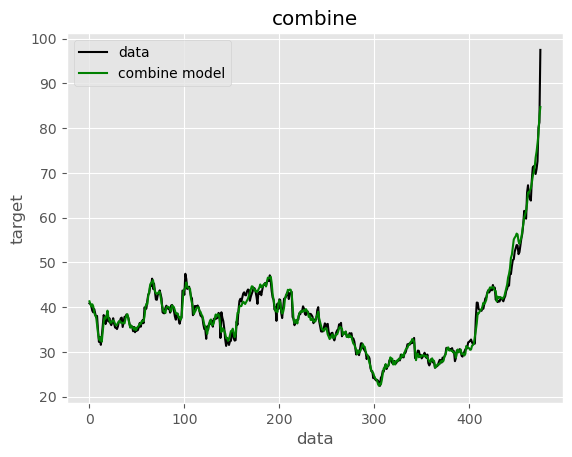

In [75]:
plt.plot(mean_actual,c='k',label='data')
plt.plot(mean_pre,c='g',label='combine model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('combine')
plt.legend()
plt.show()


In [70]:
# 傻瓜算法
stupid_actual = mean_actual
stupid_predict = [stupid_actual[0]]
stupid_predict[1:len(stupid_actual)] = stupid_actual[0:len(stupid_actual)-1]
print(len(stupid_actual))
print(len(stupid_predict))
print(stupid_actual)
print(stupid_predict)

476
476
[40.828750625000005, 40.70000075, 40.16875075, 39.19499975, 38.8187485, 39.566249875000004, 38.63750075000001, 37.692501125, 38.02249912500001, 34.897499125, 32.222499875000004, 33.266250625, 31.559999499999996, 33.441249875000004, 35.867500250000006, 38.215000124999996, 37.4124985, 36.20750050000001, 38.087501499999995, 37.61624912500001, 36.759998375, 37.54249949999999, 36.40124887500001, 35.96125025, 36.66875075000001, 37.50999837500001, 36.27999875, 35.421249375, 35.43249887500001, 35.08625025, 35.68500137499999, 36.759998375, 36.73749925, 37.490001625, 37.64374924999999, 35.5562515, 36.7612495, 37.846248625, 37.74625012499999, 38.35625075, 38.127498625, 37.63249975, 36.496250125, 35.522499125, 35.810001375, 35.56750112499999, 34.602500875, 35.56124875, 34.37625125000001, 34.883750875000004, 34.731250749999994, 34.85625075, 35.47000125000001, 36.465000124999996, 35.591251375, 36.47750087499999, 37.09249874999999, 36.391250625, 39.9375, 39.51124949999999, 39.70750050000001, 

In [71]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(stupid_actual, stupid_predict))
print("mean_squared_error:", mean_squared_error(stupid_actual, stupid_predict))
print("rmse:", sqrt(mean_squared_error(stupid_actual, stupid_predict)))
print("r2 score:", r2_score(stupid_actual, stupid_predict))

mean_absolute_error: 0.9545982203256306
mean_squared_error: 2.411379475296146
rmse: 1.5528617051418796
r2 score: 0.9704824903890008


In [72]:
trend_actual = []

for i in range(1, len(mean_actual)):
    tmp = mean_actual[i] - mean_actual[i-1]
    if tmp < 0: # down
        trend_actual.append(2)
    elif tmp > 0: # up
        trend_actual.append(0)
    else:
        trend_actual.append(1)

print(len(trend_actual))
trend_actual

475


[2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,


In [73]:
trend_predict = []

for i in range(1, len(mean_pre)):
    tmp = mean_pre[i] - mean_pre[i-1]
    if tmp < 0: # down
        trend_predict.append(2)
    elif tmp > 0: # up
        trend_predict.append(0)
    else:
        trend_predict.append(1)

trend_predict

[2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,


In [27]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(trend_actual, trend_predict))
print("mean_squared_error:", mean_squared_error(trend_actual, trend_predict))
print("rmse:", sqrt(mean_squared_error(trend_actual, trend_predict)))
print("r2 score:", r2_score(trend_actual, trend_predict))

mean_absolute_error: 0.7578947368421053
mean_squared_error: 1.5157894736842106
rmse: 1.231174022502185
r2 score: -0.5161187360357484


In [74]:
same = 0
up = []

for i in range(0, len(trend_actual)):
    if trend_actual[i] == trend_predict[i]:
        same = same + 1
        tmp = abs(mean_actual[i+1]-mean_actual[i])
        up.append(tmp)
        
ratio = same/len(trend_actual)
ratio

0.6252631578947369

In [29]:
up

[0.128749875000004,
 0.5312499999999929,
 0.973751,
 0.3762512500000028,
 0.9287491250000031,
 0.9449996250000012,
 3.125,
 2.674999249999999,
 2.426250374999988,
 2.347499875000004,
 0.8025016249999979,
 1.2049979999999962,
 0.856250750000001,
 1.1412506249999979,
 0.707500500000009,
 0.8412476249999941,
 1.229999625000005,
 0.858749374999995,
 0.011249500000005241,
 1.0749970000000033,
 0.15374762500000116,
 2.08749774999999,
 1.2049979999999962,
 1.084999124999996,
 0.610000625000005,
 0.22875212499999975,
 0.4949988750000003,
 1.1362496249999978,
 0.973751,
 0.9650002499999886,
 0.5074996249999941,
 0.1525001250000031,
 0.125,
 0.613750500000009,
 0.9949988749999861,
 0.8862494999999981,
 0.6149978750000002,
 3.546249375000002,
 0.19625100000001083,
 1.805000249999999,
 1.3337478750000002,
 0.2512512500000028,
 1.617500249999992,
 0.056251500000009,
 1.5824967500000042,
 1.8387488749999932,
 1.7350006249999979,
 0.07749937500000215,
 1.1237487499999972,
 0.3125,
 0.8724976250000083

In [28]:
np.mean(up)

1.1152878726340694